In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import heapq
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from enum import Enum

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
class EventType(Enum):
    ARRIVAL = "arrival"
    SERVICE_COMPLETION = "service_completion"
    ABANDON = "abandon"
    CHARGING_COMPLETION = "charging_completion"

@dataclass
class Event:
    time: float
    event_type: EventType
    customer_id: Optional[int] = None
    server_id: Optional[int] = None
    
    def __lt__(self, other):
        return self.time < other.time

@dataclass
class Customer:
    id: int
    arrival_time: float
    service_time: float
    patience_time: float
    
    # Results to be filled during simulation
    queue_length_on_arrival: int = 0
    servers_available_on_arrival: int = 0
    servers_occupied_on_arrival: int = 0  # NEW: servers busy serving customers
    servers_charging_on_arrival: int = 0  # NEW: servers in charging state
    system_size_on_arrival: int = 0  # Total customers in system
    wait_time: float = 0.0
    service_start_time: float = 0.0
    departure_time: float = 0.0
    charging_time: float = 0.0  # Time spent in charging (if applicable)
    abandoned: bool = False

    def get_server_state_summary(self):
        """Get a summary of server states at arrival"""
        total = self.servers_available_on_arrival + self.servers_occupied_on_arrival + self.servers_charging_on_arrival
        return {
            'available': self.servers_available_on_arrival,
            'occupied': self.servers_occupied_on_arrival,
            'charging': self.servers_charging_on_arrival,
            'total': total
        }

class QueueSimulation:
    def __init__(self, num_customers: int, lambda_rate: float, mu_rate: float, 
                 theta_rate: float, num_servers: int, p_charge: float = 0.0, 
                 gamma_rate: float = 1.0, charging_distribution: str = 'exponential',random_seed: int = 2221):
        """
        Initialize queue simulation parameters
        
        Args:
            num_customers: Fixed number of customers to simulate
            lambda_rate: Arrival rate (λ)
            mu_rate: Service rate (μ)
            theta_rate: Abandonment rate (θ)
            num_servers: Total number of servers (c)
            p_charge: Probability of going to charge after service (p)
            gamma_rate: Charging completion rate (γ)
            random_seed: Random seed for reproducibility
        """
        self.num_customers = num_customers
        self.lambda_rate = lambda_rate
        self.mu_rate = mu_rate
        self.theta_rate = theta_rate
        self.num_servers = num_servers
        self.p_charge = p_charge
        self.gamma_rate = gamma_rate
        
        np.random.seed(random_seed)
        
        # Generate all random variables upfront
        self.customers = self._generate_customers()

        # Pre-generate charging decisions for server completions
        # We need more than num_customers because servers can complete multiple services
        max_service_completions = num_customers * 3  # Conservative estimate
        self.charging_decisions = np.random.binomial(1, self.p_charge, max_service_completions)
        #print(self.charging_decisions)
        if charging_distribution == 'exponential':
            self.charging_times = np.random.exponential(1/self.gamma_rate, max_service_completions)
        elif charging_distribution == 'constant':
            self.charging_times = np.ones(max_service_completions) * (1/self.gamma_rate)  # Fixed charging time for simplicity 
        elif charging_distribution == 'uniform':
            self.charging_times = np.random.uniform(0, 2/self.gamma_rate, max_service_completions) #need to fix this
        elif charging_distribution == 'lognormal':
            self.charging_times = stats.lognorm.rvs(s=0.5, scale=np.exp(np.log(1/self.gamma_rate)), size=max_service_completions)
        else:
            raise ValueError(f"Unknown charging distribution: {charging_distribution}")
        #print(self.charging_times)
        self.charging_decision_index = 0
        
    def _generate_customers(self) -> List[Customer]:
        """Generate all customers with their random attributes"""
        customers = []
        
        # Generate inter-arrival times (exponential)
        inter_arrivals = np.random.exponential(1/self.lambda_rate, self.num_customers)
        arrival_times = np.cumsum(inter_arrivals)
        
        # Generate service times (exponential)
        service_times = np.random.exponential(1/self.mu_rate, self.num_customers)
        
        # Generate patience times (exponential)
        patience_times = np.random.exponential(1/self.theta_rate, self.num_customers)
        
        
        for i in range(self.num_customers):
            customer = Customer(
                id=i,
                arrival_time=arrival_times[i],
                service_time=service_times[i],
                patience_time=patience_times[i]
            )
            customers.append(customer)
            
        return customers
    
    def simulate_erlang_a(self) -> List[Customer]:
        """Simulate Erlang-A queue (no charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        servers = [None] * self.num_servers  # None means idle, customer_id means busy
        current_time = 0.0
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
        
        return self.customers
    
    def simulate_erlang_s(self) -> List[Customer]:
        """Simulate Erlang-S* queue (with charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        active_servers = list(range(self.num_servers))  # All servers start active
        charging_servers = []  # Servers in charging state
        server_assignments = {}  # server_id -> customer_id
        current_time = 0.0
        
        #print(f"DEBUG: Starting simulation with {self.num_servers} servers")
        #print(f"DEBUG: Initial active_servers: {active_servers}")
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_s(event, queue, active_servers, server_assignments, event_queue, charging_servers)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_s(event, queue, active_servers, charging_servers, 
                                                    server_assignments, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
            elif event.event_type == EventType.CHARGING_COMPLETION:
                # Pass all necessary parameters for serving waiting customers
                self._handle_charging_completion(event, active_servers, charging_servers, 
                                            queue, server_assignments, event_queue)
        
        #print(f"DEBUG: Final state - active: {len(active_servers)}, charging: {len(charging_servers)}, occupied: {len(server_assignments)}")
        return self.customers

    # Update the arrival handler to accept charging_servers
    def _handle_arrival_erlang_s(self, event, queue, active_servers, server_assignments, event_queue, charging_servers):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-S*
        available_servers = len(active_servers)
        occupied_servers = len(server_assignments)
        charging_servers_count = len(charging_servers)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = charging_servers_count
        
        # Verify server count consistency
        total_tracked = available_servers + occupied_servers + charging_servers_count
        if total_tracked != self.num_servers:
            print(f"DEBUG WARNING: Server count mismatch at time {event.time:.3f}")
            print(f"  Available: {available_servers}, Occupied: {occupied_servers}, Charging: {charging_servers_count}")
            print(f"  Total: {total_tracked}, Expected: {self.num_servers}")
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        if active_servers:
            # Start service immediately
            server_id = active_servers.pop(0)
            server_assignments[server_id] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, server_id))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))
        
    def _handle_arrival_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-A
        available_servers = sum(1 for s in servers if s is None)
        occupied_servers = sum(1 for s in servers if s is not None)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = 0  # No charging in Erlang-A
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        # Check if server is available
        available_server = None
        for i, server in enumerate(servers):
            if server is None:
                available_server = i
                break
        
        if available_server is not None:
            # Start service immediately
            servers[available_server] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, available_server))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))

    def _handle_charging_completion(self, event, active_servers, charging_servers, queue=None, server_assignments=None, event_queue=None):
        """Handle server charging completion - move server back to active and serve waiting customers"""
        server_id = event.server_id
        if server_id in charging_servers:
            charging_servers.remove(server_id)
            
            # Check if there are waiting customers in queue
            if queue and len(queue) > 0 and server_assignments is not None and event_queue is not None:
                # Immediately serve next customer instead of going to active list
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                
                # Assign server to customer
                server_assignments[server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                
                # Schedule service completion
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, server_id))
                
                #print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and immediately serves customer {next_customer_id}")
            else:
                # No waiting customers, add to active servers
                active_servers.append(server_id)
                #print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and becomes available")
            
            #print(f"DEBUG: Active servers now: {active_servers}")
            #print(f"DEBUG: Charging servers now: {charging_servers}")
        else:
            print(f"DEBUG: ERROR - Server {server_id} not found in charging_servers at time {event.time:.3f}")
            print(f"DEBUG: Current charging_servers: {charging_servers}")
            print(f"DEBUG: Current active_servers: {active_servers}")

    
    def _handle_service_completion_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        servers[event.server_id] = None
        
        # Check if there's a waiting customer
        if queue:
            next_customer_id = queue.pop(0)
            next_customer = self.customers[next_customer_id]
            
            # Remove abandonment event for this customer (if it exists)
            # Note: In a more sophisticated implementation, we'd track and remove the event
            
            # Start service for next customer
            servers[event.server_id] = next_customer_id
            next_customer.service_start_time = event.time
            next_customer.wait_time = event.time - next_customer.arrival_time
            
            # Schedule service completion
            completion_time = event.time + next_customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            next_customer_id, event.server_id))
    
    def _handle_service_completion_erlang_s(self, event, queue, active_servers, charging_servers, server_assignments, event_queue):
        """Handle service completion in Erlang-S* system"""
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        
        # Remove server from assignments
        if event.server_id in server_assignments:
            del server_assignments[event.server_id]
        else:
            print(f"DEBUG: WARNING - Server {event.server_id} not found in assignments")
        
        #print(f"DEBUG: Service completion for customer {customer.id} by server {event.server_id} at time {event.time:.3f}")
        #print(f"DEBUG: Queue length: {len(queue)}")
        
        # EVERY service completion should have a charging decision
        if self.charging_decision_index < len(self.charging_decisions):
            server_goes_to_charge = bool(self.charging_decisions[self.charging_decision_index])
            server_charging_time = self.charging_times[self.charging_decision_index]
            self.charging_decision_index += 1
            
            #print(f"DEBUG: Server {event.server_id} charging decision: {server_goes_to_charge}")
            
            if server_goes_to_charge:
                # Server goes to charging regardless of queue status
                charging_servers.append(event.server_id)
                #print(f"DEBUG: Server {event.server_id} starts charging for {server_charging_time:.3f} time units")
                
                # Schedule charging completion
                charging_completion_time = event.time + server_charging_time
                customer.charging_time = server_charging_time  # Record charging time for the customer
                heapq.heappush(event_queue, Event(charging_completion_time, EventType.CHARGING_COMPLETION, 
                                                None, event.server_id))
                #print(f"DEBUG: Charging completion scheduled for time {charging_completion_time:.3f}")
                
                # If there are waiting customers, they wait for this server to finish charging
                # OR other available servers can serve them
                
            else:
                # Server doesn't go charging, check if there are waiting customers
                if queue:
                    next_customer_id = queue.pop(0)
                    next_customer = self.customers[next_customer_id]
                    
                    # Use the same server that just finished
                    server_assignments[event.server_id] = next_customer_id
                    next_customer.service_start_time = event.time
                    next_customer.wait_time = event.time - next_customer.arrival_time
                    
                    #print(f"DEBUG: Server {event.server_id} immediately serves next customer {next_customer_id}")
                    
                    # Schedule service completion
                    completion_time = event.time + next_customer.service_time
                    heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                    next_customer_id, event.server_id))
                else:
                    # No waiting customers, server becomes available
                    active_servers.append(event.server_id)
                    #print(f"DEBUG: Server {event.server_id} becomes immediately available")
        else:
            # Fallback if we run out of pre-generated decisions
            if queue:
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                server_assignments[event.server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, event.server_id))
            else:
                active_servers.append(event.server_id)
                #print(f"DEBUG: Server {event.server_id} becomes available (no more charging decisions)")
        
        #print(f"DEBUG: After service completion - Active: {len(active_servers)}, Charging: {len(charging_servers)}, Occupied: {len(server_assignments)}")
        
    def _handle_abandon(self, event, queue):
        customer_id = event.customer_id
        if customer_id in queue:
            queue.remove(customer_id)
            customer = self.customers[customer_id]
            customer.abandoned = True
            customer.wait_time = event.time - customer.arrival_time
            customer.departure_time = event.time
    
    # def _handle_charging_completion(self, event, active_servers, charging_servers):
    #     server_id = event.server_id
    #     if server_id in charging_servers:
    #         charging_servers.remove(server_id)
    #         active_servers.append(server_id)


In [18]:
def analyze_and_visualize(customers_a: List[Customer], customers_s: List[Customer], 
                         params: Dict, save_plots: bool = False):
    """Analyze simulation results and create visualizations"""
    
    # Create DataFrames for analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    df_combined = pd.concat([df_a, df_s], ignore_index=True)
    
    # Print summary statistics
    print("=== SIMULATION RESULTS ===")
    print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}")
    print(f"Erlang-S* specific: p={params['p']}, γ={params['gamma']}")
    print("\nERLANG-A QUEUE:")
    print(f"  Average wait time: {df_a['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_a['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_a['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_a['servers_available_on_arrival'].mean():.3f}")
    
    print("\nERLANG-S* QUEUE:")
    print(f"  Average wait time: {df_s['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_s['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_s['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_s['servers_available_on_arrival'].mean():.3f}")
    
    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Wait Time Distributions
    plt.subplot(3, 4, 1)
    non_abandoned_a = df_a[~df_a['abandoned']]['wait_time']
    non_abandoned_s = df_s[~df_s['abandoned']]['wait_time']
    
    plt.hist(non_abandoned_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(non_abandoned_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.title('Wait Time Distribution\n(Non-abandoned customers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Queue Length on Arrival
    plt.subplot(3, 4, 2)
    queue_lengths_a = df_a['queue_length_on_arrival'].value_counts().sort_index()
    queue_lengths_s = df_s['queue_length_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(max(queue_lengths_a.index.max(), queue_lengths_s.index.max()) + 1)
    plt.bar(x_pos - 0.2, [queue_lengths_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [queue_lengths_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Queue Length on Arrival')
    plt.ylabel('Frequency')
    plt.title('Queue Length Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Servers Available on Arrival
    plt.subplot(3, 4, 3)
    servers_a = df_a['servers_available_on_arrival'].value_counts().sort_index()
    servers_s = df_s['servers_available_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(params['c'] + 1)
    plt.bar(x_pos - 0.2, [servers_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [servers_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Servers Available on Arrival')
    plt.ylabel('Frequency')
    plt.title('Available Servers Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Abandonment Comparison
    plt.subplot(3, 4, 4)
    abandon_rates = [df_a['abandoned'].mean(), df_s['abandoned'].mean()]
    systems = ['Erlang-A', 'Erlang-S*']
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = plt.bar(systems, abandon_rates, color=colors, alpha=0.7)
    plt.ylabel('Abandonment Rate')
    plt.title('Abandonment Rate Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, abandon_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{rate:.3f}', ha='center', va='bottom')
    
    # 5. Wait Time Over Time
    plt.subplot(3, 4, 5)
    window_size = max(50, len(customers_a) // 20)
    df_a_sorted = df_a.sort_values('arrival_time')
    df_s_sorted = df_s.sort_values('arrival_time')
    
    wait_time_ma_a = df_a_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    wait_time_ma_s = df_s_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    
    plt.plot(df_a_sorted['arrival_time'], wait_time_ma_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], wait_time_ma_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Wait Time (Moving Average)')
    plt.title(f'Wait Time Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Service Time vs Wait Time Scatter
    plt.subplot(3, 4, 6)
    non_abandoned_a = df_a[~df_a['abandoned']]
    non_abandoned_s = df_s[~df_s['abandoned']]
    
    plt.scatter(non_abandoned_a['service_time'], non_abandoned_a['wait_time'], 
               alpha=0.5, label='Erlang-A', s=20)
    plt.scatter(non_abandoned_s['service_time'], non_abandoned_s['wait_time'], 
               alpha=0.5, label='Erlang-S*', s=20)
    plt.xlabel('Service Time')
    plt.ylabel('Wait Time')
    plt.title('Service Time vs Wait Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Queue Length Evolution
    plt.subplot(3, 4, 7)
    plt.plot(df_a_sorted['arrival_time'], 
             df_a_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], 
             df_s_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Queue Length (Moving Average)')
    plt.title(f'Queue Length Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Wait Time Box Plot
    plt.subplot(3, 4, 8)
    wait_data = [non_abandoned_a['wait_time'], non_abandoned_s['wait_time']]
    plt.boxplot(wait_data, labels=['Erlang-A', 'Erlang-S*'])
    plt.ylabel('Wait Time')
    plt.title('Wait Time Distribution\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    
    # 9. Probability of Delay (P(Wait > 0))
    plt.subplot(3, 4, 9)
    delay_prob_a = (df_a['wait_time'] > 0).sum() / len(customers_a)
    delay_prob_s = (df_s['wait_time'] > 0).sum() / len(customers_s)
    
    bars = plt.bar(['Erlang-A', 'Erlang-S*'], [delay_prob_a, delay_prob_s], 
                   color=colors, alpha=0.7)
    plt.ylabel('Probability of Delay')
    plt.title('Probability of Delay\nP(Wait Time > 0)')
    plt.grid(True, alpha=0.3)
    
    for bar, prob in zip(bars, [delay_prob_a, delay_prob_s]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')
  
    
    # 10. System Time Distribution (Wait + Service)
    plt.subplot(3, 4, 10)
    system_time_a = non_abandoned_a['wait_time'] + non_abandoned_a['service_time']
    system_time_s = non_abandoned_s['wait_time'] + non_abandoned_s['service_time']
    
    plt.hist(system_time_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(system_time_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('System Time (Wait + Service)')
    plt.ylabel('Density')
    plt.title('System Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 11. Utilization Over Time (approximation)
    plt.subplot(3, 4, 11)
    busy_servers_a = params['c'] - df_a_sorted['servers_available_on_arrival']
    busy_servers_s = params['c'] - df_s_sorted['servers_available_on_arrival']
    
    utilization_a = busy_servers_a.rolling(window=window_size, center=True).mean() / params['c']
    utilization_s = busy_servers_s.rolling(window=window_size, center=True).mean() / params['c']
    
    plt.plot(df_a_sorted['arrival_time'], utilization_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], utilization_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Utilization (approx)')
    plt.title('Server Utilization Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 12. Performance Metrics Summary
    plt.subplot(3, 4, 12)
    metrics = ['Avg Wait Time', 'Abandonment Rate', 'Delay Probability', 'Avg Queue Length']
    erlang_a_metrics = [
        df_a['wait_time'].mean(),
        df_a['abandoned'].mean(),
        delay_prob_a,
        df_a['queue_length_on_arrival'].mean()
    ]
    erlang_s_metrics = [
        df_s['wait_time'].mean(),
        df_s['abandoned'].mean(),
        delay_prob_s,
        df_s['queue_length_on_arrival'].mean()
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, erlang_a_metrics, width, label='Erlang-A', alpha=0.7)
    plt.bar(x + width/2, erlang_s_metrics, width, label='Erlang-S*', alpha=0.7)
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('queue_simulation_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return df_combined

In [19]:
def delay_probability(customers_a: List[Customer], customers_s: List[Customer], params: Dict):
    """
    Calculate the probability of delay (waiting time > 0) for all customers.
    
    Args:
        customers_a: List of Customer objects from Erlang-A
        customers_s: List of Customer objects from Erlang-S*
        params: Dictionary of parameters
    
    Returns:
        Tuple of delay probabilities (Erlang-A, Erlang-S*)
    """
    # Create DataFrames for analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    # colors = ['#1f77b4', '#ff7f0e']
    
    # plt.figure(figsize=(5, 4))
    
    # # FIXED: Calculate delay probability correctly
    delay_prob_a = (df_a['wait_time'] > 0).sum() / len(customers_a)
    delay_prob_s = (df_s['wait_time'] > 0).sum() / len(customers_s)

    abandoned_a = df_a['abandoned'].mean()
    abandoned_s = df_s['abandoned'].mean()
    
    # bars = plt.bar(['Erlang-A', 'Erlang-S*'], [delay_prob_a, delay_prob_s], 
    #                color=colors, alpha=0.7)
    # plt.ylabel('Probability of Delay')
    # plt.title('Probability of Delay\nP(Wait Time > 0)')
    # plt.grid(True, alpha=0.3)
    
    # # Add value labels on bars
    # for bar, prob in zip(bars, [delay_prob_a, delay_prob_s]):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
    #             f'{prob:.3f}', ha='center', va='bottom')
    
    # plt.show()
    
    return delay_prob_a, delay_prob_s, abandoned_a, abandoned_s

In [20]:
import pickle
import os
from datetime import datetime


def save_simulation_results(customers_a, customers_s, df_delay, params,
                           save_dir="simulation_results",
                           filename_prefix="sim_results",
                           save_pickle: bool = False,
                           save_separate_csvs: bool = False,
                           save_json: bool = True) -> tuple:
    """
    Save simulation results. By default, only writes a single combined CSV.

    Args:
        customers_a: List of Customer objects from Erlang-A simulation
        customers_s: List of Customer objects from Erlang-S* simulation
        df_delay: Tuple (delay_prob_a, delay_prob_s, abandonment_a, abandonment_s)
        params: Dict of simulation parameters
        save_dir: Directory to save results
        filename_prefix: Prefix for saved files
        save_pickle: If True, also save a pickle with full results (default False)
        save_separate_csvs: If True, also save separate CSVs for A and S* (default False)
        save_json: If True, save small JSON summaries (default True)

    Returns:
        (files_saved, results) where files_saved is a dict of written paths.
    """
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Build results object and DataFrames
    results = {
        'params': params,
        'timestamp': timestamp,
        'num_customers': len(customers_a),
        'customers_a': customers_a,
        'customers_s': customers_s,
        'delay_results': {
            'delay_prob_a': df_delay[0],
            'delay_prob_s': df_delay[1],
            'abandoned_a': df_delay[2],
            'abandoned_s': df_delay[3],
        },
    }

    df_a = pd.DataFrame([
        {
            'customer_id': c.id,
            'arrival_time': c.arrival_time,
            'queue_length_on_arrival': c.queue_length_on_arrival,
            'system_size_on_arrival': c.system_size_on_arrival,
            'servers_available_on_arrival': c.servers_available_on_arrival,
            'servers_occupied_on_arrival': c.servers_occupied_on_arrival,
            'servers_charging_on_arrival': c.servers_charging_on_arrival,
            'wait_time': c.wait_time,
            'service_time': c.service_time,
            'service_start_time': c.service_start_time,
            'departure_time': c.departure_time,
            'charging_time': c.charging_time,
            'abandoned': c.abandoned,
            'patience_time': c.patience_time,
            'system': 'Erlang-A',
        }
        for c in customers_a
    ])

    df_s = pd.DataFrame([
        {
            'customer_id': c.id,
            'arrival_time': c.arrival_time,
            'queue_length_on_arrival': c.queue_length_on_arrival,
            'system_size_on_arrival': c.system_size_on_arrival,
            'servers_available_on_arrival': c.servers_available_on_arrival,
            'servers_occupied_on_arrival': c.servers_occupied_on_arrival,
            'servers_charging_on_arrival': c.servers_charging_on_arrival,
            'wait_time': c.wait_time,
            'service_time': c.service_time,
            'service_start_time': c.service_start_time,
            'departure_time': c.departure_time,
            'charging_time': c.charging_time,
            'abandoned': c.abandoned,
            'patience_time': c.patience_time,
            'system': 'Erlang-S*',
        }
        for c in customers_s
    ])

    results['df_erlang_a'] = df_a
    results['df_erlang_s'] = df_s
    results['df_combined'] = pd.concat([df_a, df_s], ignore_index=True)

    files_saved = {}

    # Optional: pickle (off by default)
    if save_pickle:
        pickle_file = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.pkl")
        with open(pickle_file, 'wb') as f:
            pickle.dump(results, f)
        files_saved['pickle'] = pickle_file

    # Optional: separate CSVs (off by default)
    if save_separate_csvs:
        csv_a_file = os.path.join(save_dir, f"{filename_prefix}_erlang_a_{timestamp}.csv")
        csv_s_file = os.path.join(save_dir, f"{filename_prefix}_erlang_s_{timestamp}.csv")
        df_a.to_csv(csv_a_file, index=False)
        df_s.to_csv(csv_s_file, index=False)
        files_saved['csv_erlang_a'] = csv_a_file
        files_saved['csv_erlang_s'] = csv_s_file

    # Always: combined CSV
    csv_combined_file = os.path.join(save_dir, f"{filename_prefix}_combined_{timestamp}.csv")
    results['df_combined'].to_csv(csv_combined_file, index=False)
    files_saved['csv_combined'] = csv_combined_file

    # Optional: JSON summaries
    if save_json:
        import json
        summary_stats = {
            'simulation_params': params,
            'timestamp': timestamp,
            'total_customers': len(customers_a),
            'erlang_a_stats': {
                'avg_wait_time': float(df_a['wait_time'].mean()),
                'avg_queue_length': float(df_a['queue_length_on_arrival'].mean()),
                'abandonment_rate': float(df_a['abandoned'].mean()),
                'delay_probability': float(df_delay[0]),
                'avg_servers_available': float(df_a['servers_available_on_arrival'].mean()),
                'avg_system_size': float(df_a['system_size_on_arrival'].mean()),
            },
            'erlang_s_stats': {
                'avg_wait_time': float(df_s['wait_time'].mean()),
                'avg_queue_length': float(df_s['queue_length_on_arrival'].mean()),
                'abandonment_rate': float(df_s['abandoned'].mean()),
                'delay_probability': float(df_delay[1]),
                'avg_servers_available': float(df_s['servers_available_on_arrival'].mean()),
                'avg_servers_charging': float(df_s['servers_charging_on_arrival'].mean()),
                'avg_system_size': float(df_s['system_size_on_arrival'].mean()),
                'avg_charging_time': float(df_s[df_s['charging_time'] > 0]['charging_time'].mean()) if (df_s['charging_time'] > 0).any() else 0.0,
            },
        }
        json_file = os.path.join(save_dir, f"{filename_prefix}_summary_{timestamp}.json")
        with open(json_file, 'w') as f:
            json.dump(summary_stats, f, indent=2)
        files_saved['json_summary'] = json_file

        params_file = os.path.join(save_dir, f"{filename_prefix}_params_{timestamp}.json")
        with open(params_file, 'w') as f:
            json.dump(params, f, indent=2)
        files_saved['params'] = params_file

    # Print summary
    print("\n=== SIMULATION RESULTS SAVED ===")
    print(f"Save directory: {save_dir}")
    print(f"Timestamp: {timestamp}")
    print("Files saved:")
    for k, v in files_saved.items():
        print(f"  {k}: {os.path.basename(v)}")

    print("\nQuick summary:")
    print(f"  Total customers simulated: {len(customers_a):,}")
    print(f"  Erlang-A delay probability: {df_delay[0]:.4f}")
    print(f"  Erlang-S* delay probability: {df_delay[1]:.4f}")
    print(f"  Erlang-A abandonment rate: {df_delay[2]:.4f}")
    print(f"  Erlang-S* abandonment rate: {df_delay[3]:.4f}")

    return files_saved, results


# Function to load saved results (legacy pickle loader; only works if save_pickle=True)
def load_simulation_results(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        results = pickle.load(f)
    print(f"Loaded simulation results from: {pickle_file_path}")
    print(f"Simulation timestamp: {results['timestamp']}")
    print(f"Parameters: {results['params']}")
    print(f"Number of customers: {results['num_customers']:,}")
    return results

print("Simulation save/load functions defined successfully!")

Simulation save/load functions defined successfully!


In [21]:
def run_parameter_sweep(parameter_sets, num_customers=10000, base_save_dir="simulation_results", charging_distr='exponential'):
    """
    Run multiple simulations with different parameter sets and STREAM a single summary CSV.

    This revised version:
      - DOES NOT save per-run pickle or CSV artifacts.
      - Computes ALL aggregated metrics needed downstream (staffing, plots).
      - Adds queue/server state statistics (mean/var/cov) for each system.
      - Appends each simulation's summary row immediately to the summary CSV to avoid large memory usage.

    Summary CSV columns (one row per run):
      sim_id, timestamp,
      lambda, mu, theta, c, p, gamma,
      rho, utilization,
      delay_prob_a, delay_prob_s,
      abandon_rate_a, abandon_rate_s,
      avg_wait_a, avg_wait_s,
      avg_queue_a, avg_queue_s,
      avg_servers_avail_a, avg_servers_avail_s,
      avg_servers_charging_s,
      avg_system_size_a, avg_system_size_s,
      var_queue_a, var_queue_s,
      var_servers_avail_a, var_servers_avail_s,
      cov_queue_servers_a, cov_queue_servers_s,
      var_system_size_a, var_system_size_s,
      delay_improvement, abandon_improvement, wait_improvement, queue_improvement

    Returns:
      Path to sweep directory and DataFrame of all rows (also written to disk as it builds).
    """
    import os
    import json
    from datetime import datetime
    import pandas as pd
    import numpy as np

    sweep_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sweep_dir = os.path.join(base_save_dir, f"parameter_sweep_{sweep_timestamp}")
    summary_dir = os.path.join(sweep_dir, "summary")
    os.makedirs(summary_dir, exist_ok=True)

    summary_csv_path = os.path.join(summary_dir, "parameter_sweep_summary.csv")

    # Prepare header / create file
    header_written = False
    all_rows = []  # Keep in memory for return; could be skipped if memory pressure.

    print(f"Starting summary-only parameter sweep with {len(parameter_sets)} parameter sets")
    print(f"Each simulation uses {num_customers:,} customers")
    print(f"Sweep directory: {sweep_dir}")
    print("=" * 80)

    def compute_metrics(customers):
        """Compute aggregated metrics for a list of Customer objects."""
        if not customers:
            return {
                'avg_wait': np.nan,
                'avg_queue': np.nan,
                'avg_servers_avail': np.nan,
                'avg_servers_charging': np.nan,
                'avg_system_size': np.nan,
                'var_queue': np.nan,
                'var_servers_avail': np.nan,
                'cov_queue_servers': np.nan,
                'var_system_size': np.nan
            }
        q = np.fromiter((c.queue_length_on_arrival for c in customers), float)
        s_avail = np.fromiter((c.servers_available_on_arrival for c in customers), float)
        s_charging = np.fromiter((c.servers_charging_on_arrival for c in customers), float)
        sys_sz = np.fromiter((c.system_size_on_arrival for c in customers), float)
        waits = np.fromiter((c.wait_time for c in customers), float)
        # Stats
        avg_wait = float(np.mean(waits))
        avg_queue = float(np.mean(q))
        avg_servers_avail = float(np.mean(s_avail))
        avg_servers_charging = float(np.mean(s_charging))
        avg_system_size = float(np.mean(sys_sz))
        var_queue = float(np.var(q, ddof=1)) if q.size > 1 else 0.0
        var_servers_avail = float(np.var(s_avail, ddof=1)) if s_avail.size > 1 else 0.0
        var_system_size = float(np.var(sys_sz, ddof=1)) if sys_sz.size > 1 else 0.0
        if q.size > 1:
            cov_queue_servers = float(np.cov(q, s_avail, ddof=1)[0,1])
        else:
            cov_queue_servers = 0.0
        return {
            'avg_wait': avg_wait,
            'avg_queue': avg_queue,
            'avg_servers_avail': avg_servers_avail,
            'avg_servers_charging': avg_servers_charging,
            'avg_system_size': avg_system_size,
            'var_queue': var_queue,
            'var_servers_avail': var_servers_avail,
            'cov_queue_servers': cov_queue_servers,
            'var_system_size': var_system_size
        }

    for i, params in enumerate(parameter_sets):
        sim_id = i + 1
        print(f"\nRUN {sim_id}/{len(parameter_sets)}: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}, p={params['p']}, γ={params['gamma']}")
        try:
            # Erlang-A run with regime-based server adjustment (existing heuristic retained)
            if params['lambda']/params['mu'] + params['lambda']*params['p']/params['gamma'] <= params['c']:
                # Underloaded adjustment
                num_servers_a = int(params['c'] - params['lambda']*params['p']//params['gamma'])
            else:
                # Overloaded adjustment
                num_servers_a = int(params['c'] * (params['gamma']//(params['gamma'] + params['p']*params['mu'])))
            sim_a = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=num_servers_a,
                p_charge=0.0,
                gamma_rate=params['gamma'],
                charging_distribution=charging_distr,
                random_seed=2221 + i
            )
            customers_a = sim_a.simulate_erlang_a()

            # Erlang-S* run
            sim_s = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=params['c'],
                p_charge=params['p'],
                gamma_rate=params['gamma'],
                charging_distribution=charging_distr,
                random_seed=2221 + i
            )
            customers_s = sim_s.simulate_erlang_s()

            # Delay & abandonment metrics (original function)
            df_delay = delay_probability(customers_a, customers_s, params)
            delay_prob_a, delay_prob_s, aband_a, aband_s = df_delay

            # Aggregated state metrics
            m_a = compute_metrics(customers_a)
            m_s = compute_metrics(customers_s)

            rho = params['lambda']/params['mu']
            utilization = rho/params['c']

            row = {
                'sim_id': sim_id,
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'lambda': params['lambda'], 'mu': params['mu'], 'theta': params['theta'],
                'c': params['c'], 'p': params['p'], 'gamma': params['gamma'],
                'rho': rho, 'utilization': utilization,
                'delay_prob_a': delay_prob_a, 'delay_prob_s': delay_prob_s,
                'abandon_rate_a': aband_a, 'abandon_rate_s': aband_s,
                'avg_wait_a': m_a['avg_wait'], 'avg_wait_s': m_s['avg_wait'],
                'avg_queue_a': m_a['avg_queue'], 'avg_queue_s': m_s['avg_queue'],
                'avg_servers_avail_a': m_a['avg_servers_avail'], 'avg_servers_avail_s': m_s['avg_servers_avail'],
                'avg_servers_charging_s': m_s['avg_servers_charging'],
                'avg_system_size_a': m_a['avg_system_size'], 'avg_system_size_s': m_s['avg_system_size'],
                'var_queue_a': m_a['var_queue'], 'var_queue_s': m_s['var_queue'],
                'var_servers_avail_a': m_a['var_servers_avail'], 'var_servers_avail_s': m_s['var_servers_avail'],
                'cov_queue_servers_a': m_a['cov_queue_servers'], 'cov_queue_servers_s': m_s['cov_queue_servers'],
                'var_system_size_a': m_a['var_system_size'], 'var_system_size_s': m_s['var_system_size'],
                'delay_improvement': delay_prob_a - delay_prob_s,
                'abandon_improvement': aband_a - aband_s,
                'wait_improvement': m_a['avg_wait'] - m_s['avg_wait'],
                'queue_improvement': m_a['avg_queue'] - m_s['avg_queue']
            }

            # Append to CSV immediately
            df_row = pd.DataFrame([row])
            if not header_written:
                df_row.to_csv(summary_csv_path, index=False, mode='w')
                header_written = True
            else:
                df_row.to_csv(summary_csv_path, index=False, mode='a', header=False)

            all_rows.append(row)
            print(f"  ✓ Completed sim {sim_id}: delay_a={delay_prob_a:.4f}, delay_s={delay_prob_s:.4f}, abandon_a={aband_a:.4f}, abandon_s={aband_s:.4f}")
        except Exception as e:
            print(f"  ✗ Error in simulation {sim_id}: {e}")

    # Write parameter sets JSON (metadata)
    params_meta_path = os.path.join(summary_dir, f"parameter_sets_{sweep_timestamp}.json")
    with open(params_meta_path, 'w') as f:
        json.dump({'timestamp': sweep_timestamp,
                   'num_simulations': len(parameter_sets),
                   'num_customers_per_sim': num_customers,
                   'parameter_sets': parameter_sets}, f, indent=2)

    # README (no individual_runs directory now)
    readme_file = os.path.join(sweep_dir, "README.md")
    with open(readme_file, 'w') as f:
        f.write(f"# Parameter Sweep Results - {sweep_timestamp}\n\n")
        f.write(f"## Overview\n")
        f.write(f"- Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"- Simulations: {len(parameter_sets)}\n")
        f.write(f"- Customers per simulation: {num_customers:,}\n")
        f.write(f"- Summary CSV: parameter_sweep_summary.csv\n")
        f.write(f"\n## Columns\n")
        f.write("| Column | Description |\n")
        f.write("|--------|-------------|\n")
        for col, desc in [
            ("sim_id", "Simulation index (1-based)"),
            ("lambda", "Arrival rate λ"),
            ("mu", "Service rate μ"),
            ("theta", "Abandonment rate θ"),
            ("c", "Number of servers"),
            ("p", "Charging probability"),
            ("gamma", "Charging rate γ"),
            ("delay_prob_a", "Delay probability Erlang-A"),
            ("delay_prob_s", "Delay probability Erlang-S*"),
            ("abandon_rate_a", "Abandonment fraction Erlang-A"),
            ("abandon_rate_s", "Abandonment fraction Erlang-S*"),
            ("avg_queue_s", "Mean queue length S*"),
            ("var_queue_s", "Queue length variance S*"),
            ("avg_servers_avail_s", "Mean available servers S*"),
            ("var_servers_avail_s", "Variance available servers S*"),
            ("cov_queue_servers_s", "Covariance queue vs servers S*"),
        ]:
            f.write(f"| {col} | {desc} |\n")
        f.write("\n## Notes\n")
        f.write("Per-run raw customer trajectories are discarded to conserve disk space.\n")

    print("\nPARAMETER SWEEP COMPLETED (summary-only mode)")
    print(f"Summary CSV: {summary_csv_path}")
    print(f"Metadata JSON: {params_meta_path}")
    print(f"README: {readme_file}")

    return pd.DataFrame(all_rows), sweep_dir

print("Revised run_parameter_sweep defined (summary-only, no per-run artifacts).")

Revised run_parameter_sweep defined (summary-only, no per-run artifacts).


In [22]:
def analyze_parameter_sweep_results(all_results=None, sweep_dir=None):
    """
    Analyze and visualize results from parameter sweep.

    Accepts either:
      - all_results: DataFrame returned by run_parameter_sweep (summary-only mode), or
      - all_results: list of result dicts (legacy), or
      - None + sweep_dir: will load summary CSV from sweep_dir/summary/parameter_sweep_summary.csv.

    Returns the summary DataFrame used for plots and prints.
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # ---- Resolve df_summary from inputs ----
    df_summary = None
    if isinstance(all_results, pd.DataFrame):
        if all_results.empty:
            print("No results to analyze (empty DataFrame).")
            return all_results
        df_summary = all_results.copy()
    elif isinstance(all_results, list):
        if not all_results:
            print("No results to analyze!")
            return None
        # Build DataFrame from legacy results list
        summary_data = []
        for result in all_results:
            params = result['params']
            metrics_a = result['metrics']['erlang_a']
            metrics_s = result['metrics']['erlang_s']
            row = {
                'sim_id': result['simulation_id'],
                'lambda': params['lambda'],
                'mu': params['mu'],
                'theta': params['theta'],
                'c': params['c'],
                'p': params['p'],
                'gamma': params['gamma'],
                'rho': params['lambda'] / params['mu'],  # Traffic intensity
                'utilization': (params['lambda'] / params['mu']) / params['c'],
                # Erlang-A metrics
                'delay_prob_a': metrics_a['delay_prob'],
                'abandon_rate_a': metrics_a['abandonment_rate'],
                'avg_wait_a': metrics_a['avg_wait_time'],
                'avg_queue_a': metrics_a['avg_queue_length'],
                # Erlang-S* metrics
                'delay_prob_s': metrics_s['delay_prob'],
                'abandon_rate_s': metrics_s['abandonment_rate'],
                'avg_wait_s': metrics_s['avg_wait_time'],
                'avg_queue_s': metrics_s['avg_queue_length'],
                # Improvements (S* vs A)
                'delay_improvement': metrics_a['delay_prob'] - metrics_s['delay_prob'],
                'abandon_improvement': metrics_a['abandonment_rate'] - metrics_s['abandonment_rate'],
                'wait_improvement': metrics_a['avg_wait_time'] - metrics_s['avg_wait_time'],
                'queue_improvement': metrics_a['avg_queue_length'] - metrics_s['avg_queue_length']
            }
            summary_data.append(row)
        df_summary = pd.DataFrame(summary_data)
    else:
        # Load from sweep_dir CSV if provided
        if sweep_dir is None:
            print("No results provided and no sweep_dir to load from.")
            return None
        summary_csv = os.path.join(sweep_dir, "summary", "parameter_sweep_summary.csv")
        if not os.path.exists(summary_csv):
            raise FileNotFoundError(f"summary CSV not found: {summary_csv}")
        df_summary = pd.read_csv(summary_csv)

    # ---- Output dirs ----
    if sweep_dir:
        summary_dir = os.path.join(sweep_dir, "summary")
        plots_dir = os.path.join(sweep_dir, "plots")
        os.makedirs(plots_dir, exist_ok=True)
    else:
        summary_dir = "simulation_results"
        plots_dir = "simulation_results"

    # ---- Print summary ----
    print("=" * 100)
    print("PARAMETER SWEEP ANALYSIS")
    print("=" * 100)
    print(f"Total simulations: {len(df_summary)}")
    print("Parameter ranges:")
    print(f"  λ (arrival rate): {df_summary['lambda'].min():.1f} - {df_summary['lambda'].max():.1f}")
    print(f"  μ (service rate): {df_summary['mu'].min():.1f} - {df_summary['mu'].max():.1f}")
    print(f"  θ (abandon rate): {df_summary['theta'].min():.1f} - {df_summary['theta'].max():.1f}")
    print(f"  c (servers): {df_summary['c'].min()} - {df_summary['c'].max()}")
    print(f"  p (charge prob): {df_summary['p'].min():.1f} - {df_summary['p'].max():.1f}")
    print(f"  γ (charge rate): {df_summary['gamma'].min():.1f} - {df_summary['gamma'].max():.1f}")

    print("\nOverall Performance Improvements (Erlang-S* vs Erlang-A):")
    print("  Abandonment rate reduction:")
    print(f"    Mean: {df_summary['abandon_improvement'].mean():.4f}")
    print(f"    Min:  {df_summary['abandon_improvement'].min():.4f}")
    print(f"    Max:  {df_summary['abandon_improvement'].max():.4f}")

    print("  Wait time reduction:")
    print(f"    Mean: {df_summary['wait_improvement'].mean():.4f}")
    print(f"    Min:  {df_summary['wait_improvement'].min():.4f}")
    print(f"    Max:  {df_summary['wait_improvement'].max():.4f}")

    # ---- Plots ----
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # 1. Abandonment rate comparison
    ax = axes[0, 0]
    x = np.arange(len(df_summary))
    width = 0.35
    ax.bar(x - width/2, df_summary['abandon_rate_a'], width, label='Erlang-A', alpha=0.7)
    ax.bar(x + width/2, df_summary['abandon_rate_s'], width, label='Erlang-S*', alpha=0.7)
    ax.set_xlabel('Simulation ID')
    ax.set_ylabel('Abandonment Rate')
    ax.set_title('Abandonment Rate Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Wait time comparison
    ax = axes[0, 1]
    ax.bar(x - width/2, df_summary['avg_wait_a'], width, label='Erlang-A', alpha=0.7)
    ax.bar(x + width/2, df_summary['avg_wait_s'], width, label='Erlang-S*', alpha=0.7)
    ax.set_xlabel('Simulation ID')
    ax.set_ylabel('Average Wait Time')
    ax.set_title('Average Wait Time Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Improvement vs charging probability
    ax = axes[1, 0]
    scatter = ax.scatter(df_summary['p'], df_summary['abandon_improvement'], 
                        c=df_summary['gamma'], cmap='viridis', s=60, alpha=0.7)
    ax.set_xlabel('Charging Probability (p)')
    ax.set_ylabel('Abandonment Rate Improvement')
    ax.set_title('Abandonment Improvement vs Charging Probability')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Charging Rate (γ)')

    # 4. Improvement vs traffic intensity
    ax = axes[1, 1]
    scatter = ax.scatter(df_summary['utilization'], df_summary['abandon_improvement'], 
                        c=df_summary['p'], cmap='plasma', s=60, alpha=0.7)
    ax.set_xlabel('System Utilization (ρ/c)')
    ax.set_ylabel('Abandonment Rate Improvement')
    ax.set_title('Abandonment Improvement vs System Utilization')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Charging Probability (p)')

    # 5. Best and worst performing scenarios
    ax = axes[2, 0]
    top_5 = df_summary.nlargest(5, 'abandon_improvement')
    ax.barh(range(len(top_5)), top_5['abandon_improvement'])
    ax.set_yticks(range(len(top_5)))
    ax.set_yticklabels([f"Sim {row['sim_id']}: p={row['p']:.1f}, γ={row['gamma']:.1f}" 
                       for _, row in top_5.iterrows()])
    ax.set_xlabel('Abandonment Rate Improvement')
    ax.set_title('Top 5 Improvements')
    ax.grid(True, alpha=0.3)

    # 6. Parameter correlation heatmap
    ax = axes[2, 1]
    corr_vars = ['p', 'gamma', 'c', 'lambda', 'theta', 'abandon_improvement', 'wait_improvement']
    correlation_matrix = df_summary[corr_vars].corr()
    im = ax.imshow(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr_vars)))
    ax.set_yticks(range(len(corr_vars)))
    ax.set_xticklabels(corr_vars, rotation=45)
    ax.set_yticklabels(corr_vars)
    ax.set_title('Parameter Correlation Matrix')

    # Annotate heatmap
    for i in range(len(corr_vars)):
        for j in range(len(corr_vars)):
            _ = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                        ha="center", va="center", color="black", fontsize=8)

    plt.colorbar(im, ax=ax)
    plt.tight_layout()

    # Save plots
    plots_file = os.path.join(plots_dir, "parameter_sweep_analysis.png")
    plt.savefig(plots_file, dpi=300, bbox_inches='tight')
    print(f"Plots saved to: {plots_file}")
    plt.show()

    # Save summary CSV (if we created/modified or to ensure consistent location)
    summary_file = os.path.join(summary_dir, "parameter_sweep_summary.csv")
    try:
        df_summary.to_csv(summary_file, index=False)
        print(f"Summary saved to: {summary_file}")
    except Exception as e:
        print(f"Warning: could not write summary CSV ({e}).")

    return df_summary

print("Updated analysis functions defined successfully!")

Updated analysis functions defined successfully!


In [23]:
# Quick test run of the revised summary-only sweep (redefines parameter_sets locally)
print("Starting test parameter sweep (summary-only mode)...")

parameter_sets = [
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 1.0},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.1},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 0.5, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 2.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.8, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.1, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 10.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 100.0, 'mu': 0.5, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 10},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 1.0},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.1},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 0.5, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 2.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.8, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.1, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 10.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 120.0, 'mu': 0.5, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 10},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 1.0},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.1},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 0.5, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 2.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.8, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.1, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 10.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
    {'lambda': 80.0, 'mu': 0.5, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 0.5},
]

# Smaller customer count for fast validation
# results_df, sweep_directory = run_parameter_sweep(parameter_sets, num_customers=500)

# print("\nTest sweep complete.")
# print("Results DataFrame head:")
# print(results_df.head())
# print(f"Stored summary at: {sweep_directory}/summary/parameter_sweep_summary.csv")

Starting test parameter sweep (summary-only mode)...


In [24]:
# Comprehensive comparison and sensitivity analysis plots built from summary_df/results

def plot_parameter_comparison(summary_df_=None, results_=None, max_groups: int = 8):
    """
    Create a 3x3 panel comparing Erlang-A vs Erlang-S* across parameter variations.
    Uses summary_df (from analyze_parameter_sweep_results) if provided or available globally.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Resolve inputs
    df = summary_df_ if summary_df_ is not None else globals().get('summary_df', None)
    if df is None:
        # Try to build from results
        res = results_ if results_ is not None else globals().get('results', None)
        if res is None or not res:
            print("No data available: provide summary_df or results.")
            return
        df = analyze_parameter_sweep_results(res)

    # Ensure required columns exist
    required = {'c','theta','p','gamma', 'lambda','mu',
                'delay_prob_a','delay_prob_s','abandon_rate_a','abandon_rate_s'}
    missing = required - set(df.columns)
    if missing:
        print(f"Missing columns in summary_df: {missing}")
        return

    # Build grouping over parameter sets that vary (theta, p, gamma). Limit groups for readability.
    group_cols = ['theta','p','gamma']
    uniq_groups = df[group_cols].drop_duplicates()
    if len(uniq_groups) > max_groups:
        print(f"Warning: too many groups ({len(uniq_groups)}). Showing first {max_groups} by default.")
        uniq_groups = uniq_groups.head(max_groups)

    # Prepare color cycle
    base_colors = ['black','red','orange','blue','cyan','green','purple','brown','magenta']
    colors = base_colors[:len(uniq_groups)]

    # Common c values
    c_vals = sorted(df['c'].unique())

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Parameter Sensitivity Analysis: Erlang-A vs Erlang-S*', fontsize=16, fontweight='bold')

    # Plot 1: Delay Probability - Erlang-A
    ax = axes[0, 0]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        series = dfg.groupby('c')['delay_prob_a'].mean().reindex(c_vals)
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, series.values, 'o-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Delay Probability P(W > 0)')
    ax.set_title('Erlang-A: Delay Probability')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Plot 2: Delay Probability - Erlang-S*
    ax = axes[0, 1]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        series = dfg.groupby('c')['delay_prob_s'].mean().reindex(c_vals)
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, series.values, 's-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Delay Probability P(W > 0)')
    ax.set_title('Erlang-S*: Delay Probability')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Plot 3: Delay Probability Difference (S* - A)
    ax = axes[0, 2]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        a = dfg.groupby('c')['delay_prob_a'].mean().reindex(c_vals)
        s = dfg.groupby('c')['delay_prob_s'].mean().reindex(c_vals)
        diff = s.values - a.values
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, diff, 'o-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Δ Delay Prob (S* - A)')
    ax.set_title('Charging Impact on Delay Probability')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 4: Abandonment Rate - Erlang-A
    ax = axes[1, 0]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        series = dfg.groupby('c')['abandon_rate_a'].mean().reindex(c_vals)
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, series.values, 'o-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Abandonment Rate')
    ax.set_title('Erlang-A: Abandonment Rate')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 5: Abandonment Rate - Erlang-S*
    ax = axes[1, 1]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        series = dfg.groupby('c')['abandon_rate_s'].mean().reindex(c_vals)
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, series.values, 's-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Abandonment Rate')
    ax.set_title('Erlang-S*: Abandonment Rate')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 6: Abandonment Rate Difference (S* - A)
    ax = axes[1, 2]
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        a = dfg.groupby('c')['abandon_rate_a'].mean().reindex(c_vals)
        s = dfg.groupby('c')['abandon_rate_s'].mean().reindex(c_vals)
        diff = s.values - a.values
        label = f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}"
        ax.plot(c_vals, diff, 'o-', color=colors[i%len(colors)], alpha=0.9, linewidth=2, markersize=4, label=label)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Δ Abandonment (S* - A)')
    ax.set_title('Charging Impact on Abandonment Rate')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 7: System Utilization (ρ/c)
    ax = axes[2, 0]
    # Use first row to compute rho; note this is independent of c here
    if not df.empty:
        rho = float(df.iloc[0]['lambda']) / float(df.iloc[0]['mu'])
    else:
        rho = 0.0
    utilization = [rho / c for c in c_vals]
    ax.plot(c_vals, utilization, 'k-', linewidth=3, alpha=0.9, label=f'ρ/c (ρ={rho:.2f})')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='ρ/c = 1')
    ax.axhline(y=0.8, color='orange', linestyle=':', alpha=0.7, label='ρ/c = 0.8')
    ax.set_xlabel('Number of Servers (c)')
    ax.set_ylabel('Utilization (ρ/c)')
    ax.set_title('System Utilization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, min(2.0, max(utilization)*1.1 if utilization else 1.0))

    # Plot 8: Parameter sets table (unique combinations of θ, p, γ)
    ax = axes[2, 1]
    ax.axis('off')
    uniq = df[group_cols].drop_duplicates().reset_index(drop=True)
    table_data = [['Set', 'θ', 'p', 'γ']]
    for idx, row in uniq.iterrows():
        table_data.append([str(idx+1), f"{row['theta']}", f"{row['p']}", f"{row['gamma']}"])
    table = ax.table(cellText=table_data[1:], colLabels=table_data[0], cellLoc='center', loc='center', bbox=[0,0,1,1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax.set_title('Parameter Sets', fontweight='bold')

    # Plot 9: Summary statistics
    ax = axes[2, 2]
    ax.axis('off')
    summary_text = "SUMMARY STATISTICS\n" + "="*30 + "\n\n"
    for i, (_, g) in enumerate(uniq_groups.iterrows()):
        dfg = df[(df['theta']==g['theta']) & (df['p']==g['p']) & (df['gamma']==g['gamma'])]
        a_delay = dfg.groupby('c')['delay_prob_a'].mean().reindex(c_vals)
        s_delay = dfg.groupby('c')['delay_prob_s'].mean().reindex(c_vals)
        a_ab = dfg.groupby('c')['abandon_rate_a'].mean().reindex(c_vals)
        s_ab = dfg.groupby('c')['abandon_rate_s'].mean().reindex(c_vals)
        delay_diff = (s_delay - a_delay).values
        ab_diff = (s_ab - a_ab).values
        summary_text += f"θ={g['theta']}, p={g['p']}, γ={g['gamma']}:\n"
        summary_text += f"  Max Δ delay: {np.nanmax(delay_diff):.4f}\n"
        summary_text += f"  Max Δ abandon: {np.nanmax(ab_diff):.4f}\n\n"
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10, va='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

# Generate the comparison plots using existing summary_df (from the sweep)
plot_parameter_comparison()


No data available: provide summary_df or results.


In [25]:
# Representative-run saver (3-5 detailed runs: 2 UL, 2 OL, 1 near-critical)
import os
import math
import json
import numpy as np
import pandas as pd

def is_underloaded(lmbda, mu, p, gamma, c) -> bool:
    """
    UL if λ/μ + λ p / γ <= c  (fluid fixed point condition).
    """
    return (lmbda / mu + lmbda * p / gamma) <= c + 1e-12

def classify_regime(lmbda, mu, theta, p, gamma, c) -> str:
    return "UL" if is_underloaded(lmbda, mu, p, gamma, c) else "OL"


def save_sampled_individual_runs(parameter_sets: list,
                                 num_customers: int,
                                 sweep_dir: str,
                                 prefix: str = "sim",
                                 charging_distr: str = 'exponential'
                                 ) -> pd.DataFrame:
    """
    Run and save 3–5 detailed individual runs in sweep_dir/individual_runs using the
    same rich format (pickle + CSVs) as before.

    Returns a small DataFrame index with filenames and tags.
    """
    individual_dir = os.path.join(sweep_dir, "individual_runs")
    os.makedirs(individual_dir, exist_ok=True)

    selected = []

    for param in parameter_sets:
        regime = classify_regime(param['lambda'], param['mu'], param['theta'], param['p'], param['gamma'], param['c'])
        selected.append((param, regime))

    index_rows = []
    for idx, (params, tag) in enumerate(selected, start=1):
        print(f"Saving sampled run {idx}/{len(selected)} [{tag}] with params: "
              f"λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}, p={params['p']}, γ={params['gamma']}")

        # Match Erlang-A server adjustment from sweep logic
        if params['lambda']/params['mu'] + params['lambda']*params['p']/params['gamma'] <= params['c']:
            num_servers_a = int(params['c'] - params['lambda']*params['p']//params['gamma'])
        else:
            num = int(params['c'] * (params['gamma']//(params['gamma'] + params['p']*params['mu'])))
            num_servers_a = max(1,num)

        # Run Erlang-A
        sim_a = QueueSimulation(
            num_customers=num_customers,
            lambda_rate=params['lambda'],
            mu_rate=params['mu'],
            theta_rate=params['theta'],
            num_servers=num_servers_a,
            p_charge=0.0,
            gamma_rate=params['gamma'],
            charging_distribution=charging_distr,
            random_seed=4451 + idx
        )
        customers_a = sim_a.simulate_erlang_a()

        # Run Erlang-S*
        sim_s = QueueSimulation(
            num_customers=num_customers,
            lambda_rate=params['lambda'],
            mu_rate=params['mu'],
            theta_rate=params['theta'],
            num_servers=params['c'],
            p_charge=params['p'],
            gamma_rate=params['gamma'],
            charging_distribution=charging_distr,
            random_seed=4451 + idx
        )
        customers_s = sim_s.simulate_erlang_s()

        # Metrics and save
        df_delay = delay_probability(customers_a, customers_s, params)
        fname_prefix = f"{prefix}_{idx:02d}_{tag}_drone_delivery"
        files_saved, _ = save_simulation_results(
            customers_a=customers_a,
            customers_s=customers_s,
            df_delay=df_delay,
            params=params,
            save_dir=individual_dir,
            filename_prefix=fname_prefix
        )

        index_rows.append({
            'idx': idx,
            'tag': tag,
            'lambda': params['lambda'], 'mu': params['mu'], 'theta': params['theta'],
            'c': params['c'], 'p': params['p'], 'gamma': params['gamma'],
            'csv_combined': os.path.basename(files_saved.get('csv_combined', '')),
        })

    df_index = pd.DataFrame(index_rows)
    # Write a compact index file
    index_path = os.path.join(sweep_dir, "summary", "sampled_runs_index.csv")
    try:
        df_index.to_csv(index_path, index=False)
        print(f"Sampled runs index saved: {index_path}")
    except Exception as e:
        print(f"Warning: could not save sampled runs index ({e}).")

    print(f"Saved {len(df_index)} sampled individual runs under: {individual_dir}")
    return df_index



## High-capacity sweep (c = 50..250 by 5)


We expand each existing parameter set across a larger range of servers `c in {50, 55, ..., 250}` and run the same pipeline. Use the quick-run example to sanity-check a small subset before launching the full sweep.

Base parameter sets: 30
Total expanded sets (dynamic c ranges): 5995
Starting summary-only parameter sweep with 5995 parameter sets
Each simulation uses 100,000 customers
Sweep directory: simulation_results/parameter_sweep_20251124_021950

RUN 1/5995: λ=100.0, μ=1.0, θ=1.0, c=5, p=0.5, γ=10.0
  ✓ Completed sim 1: delay_a=1.0000, delay_s=1.0000, abandon_a=1.0000, abandon_s=0.9521

RUN 2/5995: λ=100.0, μ=1.0, θ=1.0, c=6, p=0.5, γ=10.0
  ✓ Completed sim 1: delay_a=1.0000, delay_s=1.0000, abandon_a=1.0000, abandon_s=0.9521

RUN 2/5995: λ=100.0, μ=1.0, θ=1.0, c=6, p=0.5, γ=10.0
  ✓ Completed sim 2: delay_a=1.0000, delay_s=0.9999, abandon_a=1.0000, abandon_s=0.9430

RUN 3/5995: λ=100.0, μ=1.0, θ=1.0, c=7, p=0.5, γ=10.0
  ✓ Completed sim 2: delay_a=1.0000, delay_s=0.9999, abandon_a=1.0000, abandon_s=0.9430

RUN 3/5995: λ=100.0, μ=1.0, θ=1.0, c=7, p=0.5, γ=10.0
  ✓ Completed sim 3: delay_a=1.0000, delay_s=0.9999, abandon_a=1.0000, abandon_s=0.9352

RUN 4/5995: λ=100.0, μ=1.0, θ=1.0, c=8, p=0.5

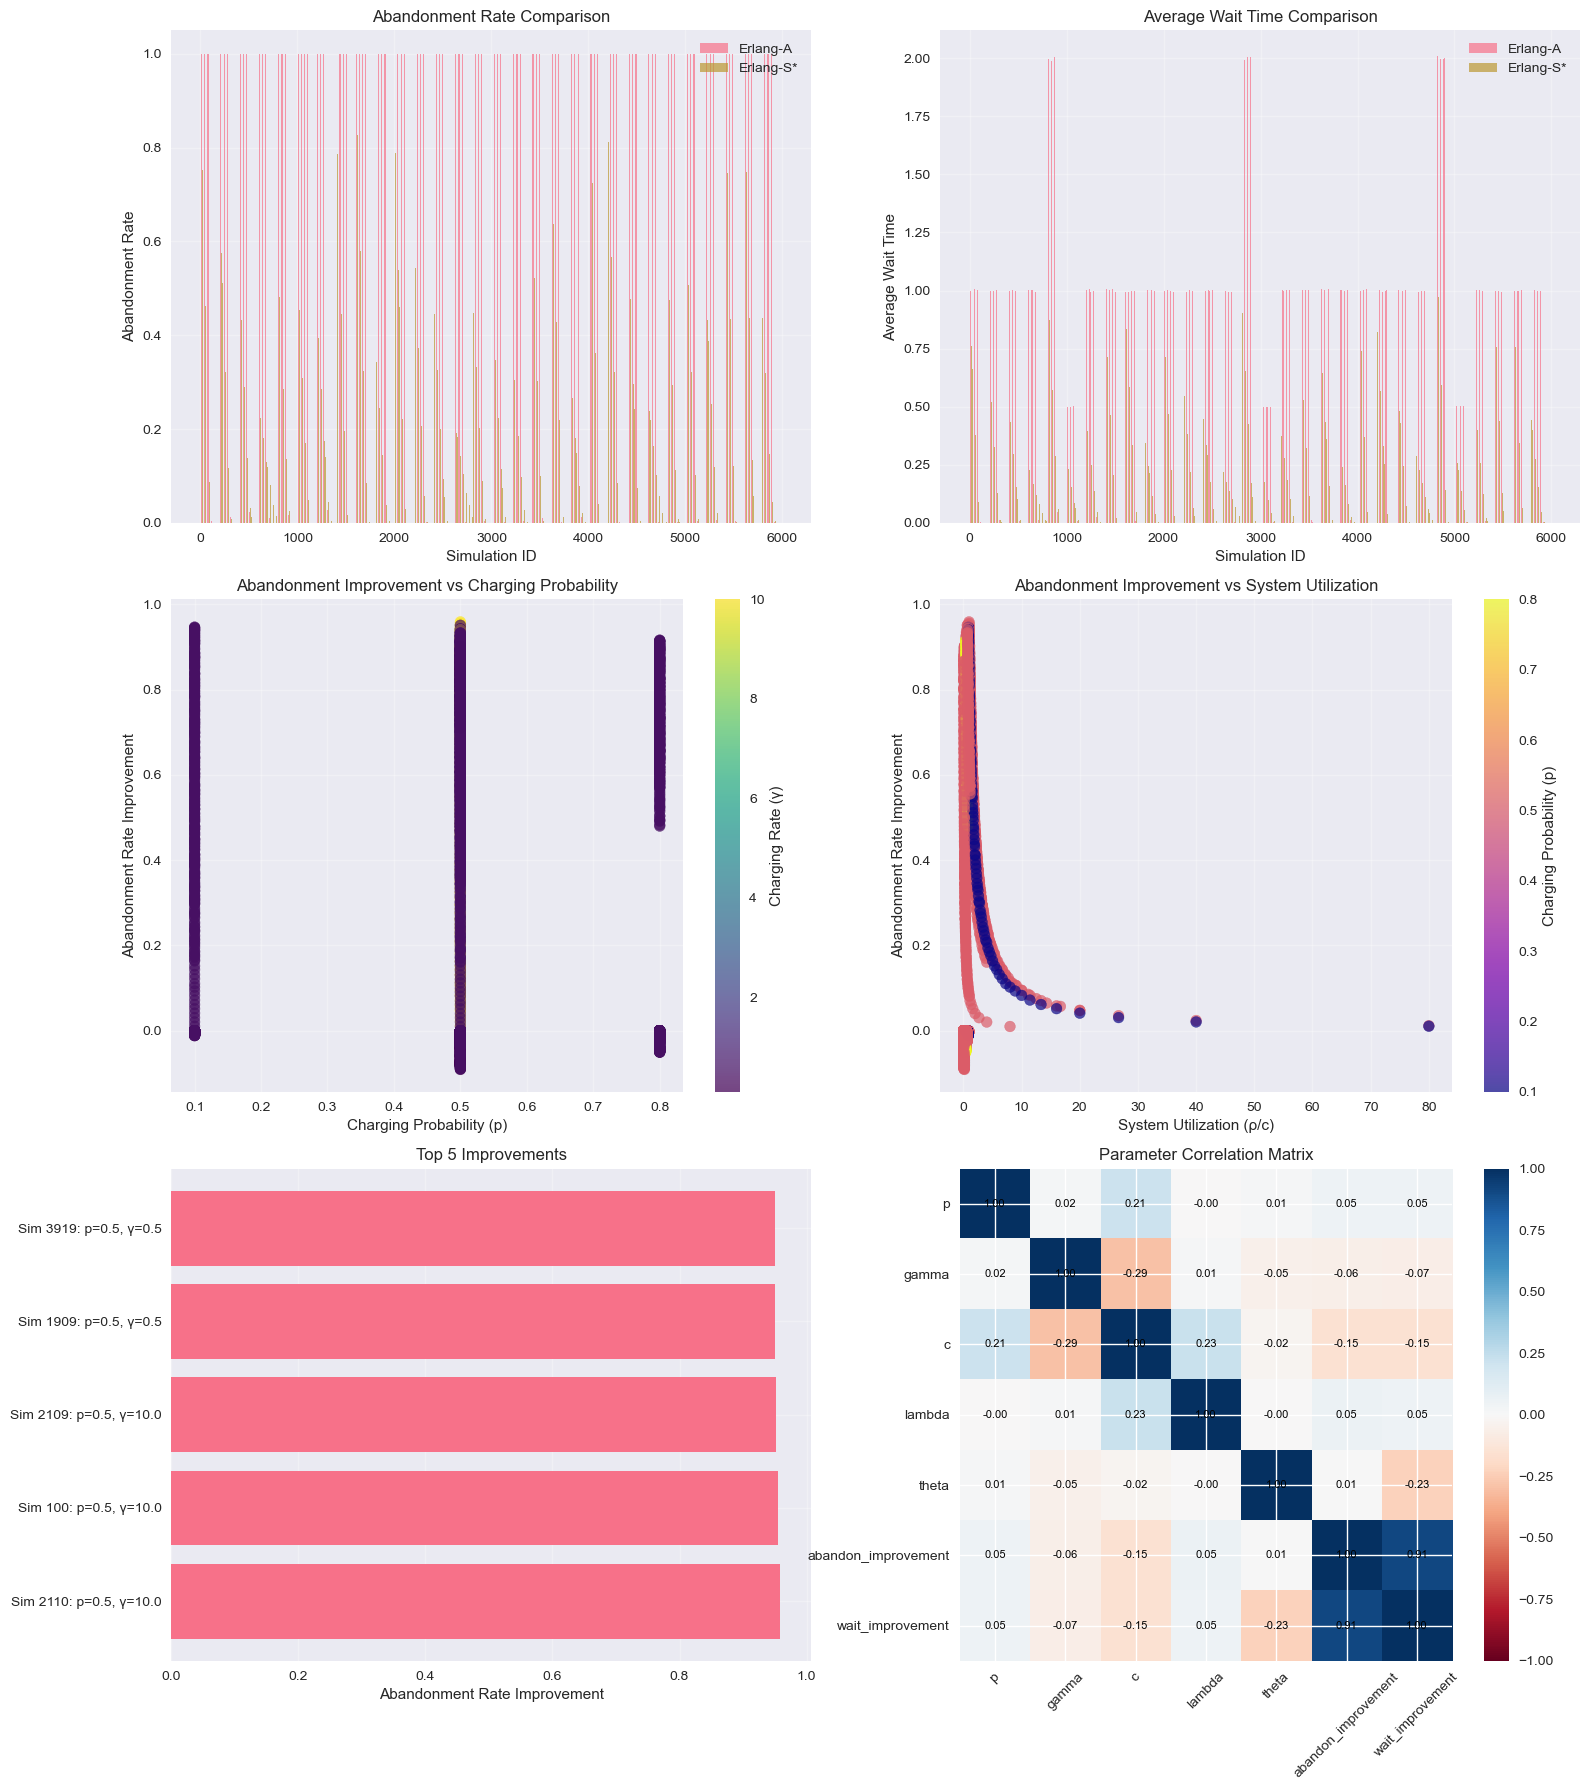

Summary saved to: simulation_results/parameter_sweep_20251124_021950/summary/parameter_sweep_summary.csv


In [12]:
# Build expanded parameter sets with a dynamic c-range centered on fluid load L = λ/μ + λ p / γ
# Original (static) version used a fixed grid 50..250. We now shift per parameter set so that
# we explore a meaningful UL/OL neighborhood: [L-100, L+100] (clipped at MIN_C).
# This cell is the right place for the change; no need to touch the Customer/QueueSimulation classes above.

import copy, math

C_SPAN_LEFT = 100   # extend this many units below L
C_SPAN_RIGHT = 100  # extend this many units above L
MIN_C = 1           # safeguard lower bound
STEP_C = 1          # step size (can raise to 2 or 5 for speed)

expanded_parameter_sets = []
for base in parameter_sets:
    L = base['lambda']/base['mu'] + base['lambda']*base['p']/base['gamma']  # fluid load threshold
    c_min = max(MIN_C, int(math.floor(L - C_SPAN_LEFT)))
    c_max = int(math.ceil(L + C_SPAN_RIGHT))
    for c_val in range(c_min, c_max + 1, STEP_C):
        p = copy.deepcopy(base)
        p['c'] = c_val
        p['load_center_L'] = L  # store for downstream inspection if needed
        expanded_parameter_sets.append(p)

print(f"Base parameter sets: {len(parameter_sets)}")
print(f"Total expanded sets (dynamic c ranges): {len(expanded_parameter_sets)}")
# print("Preview (first 6):")
# print(expanded_parameter_sets[:6])

# Optional quick dry run (small slice) to sanity-check before full sweep. Uncomment to use.
# results_quick, sweep_dir_quick = run_parameter_sweep(expanded_parameter_sets[:12], num_customers=10_000)
# summary_quick = analyze_parameter_sweep_results(results_quick, sweep_dir_quick)
# print("Quick sweep stored at:", sweep_dir_quick)

# Full dynamic sweep (comment out if not ready). Adjust num_customers for fidelity vs runtime.
results_highc, sweep_dir_highc = run_parameter_sweep(expanded_parameter_sets, num_customers=100_000, charging_distr='lognormal')
summary_highc = analyze_parameter_sweep_results(results_highc, sweep_dir_highc)

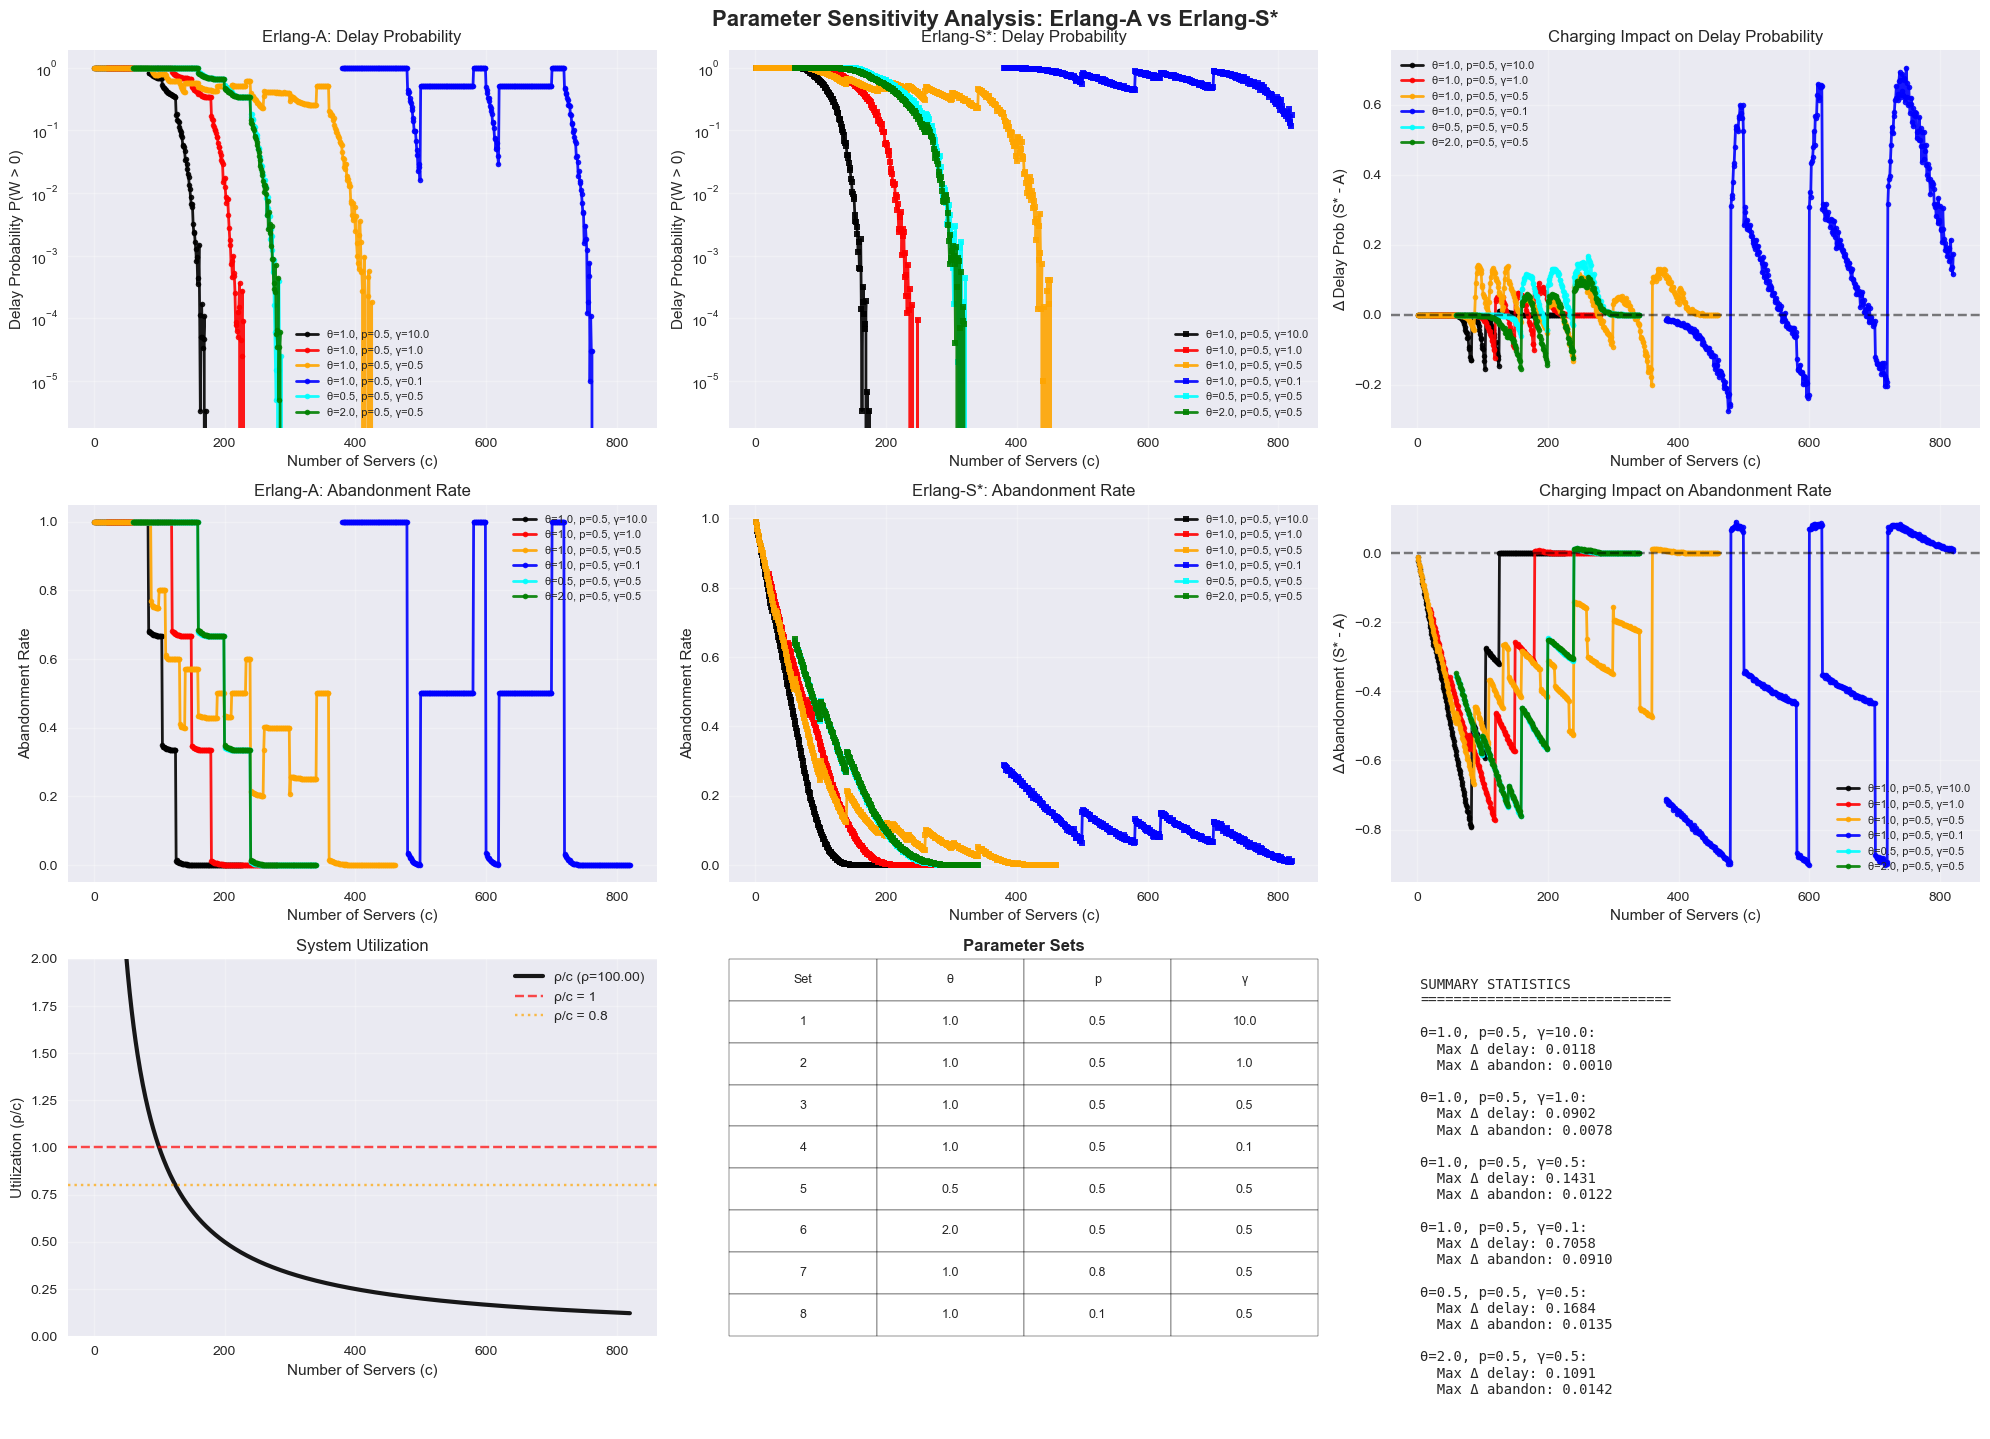

In [13]:
plot_parameter_comparison(summary_df_=summary_highc, results_=results_highc, max_groups=6)

Starting parameter sweep with 8 parameter sets
Each simulation will use 10,000 customers
Results will be saved in: simulation_results/parameter_sweep_20251106_015836

RUNNING SIMULATION 1/8
Parameters: λ=100.0, μ=1.0, θ=1.0, c=90, p=0.5, γ=10.0
  Running Erlang-A...

Overloaded system detected for Erlang-A. Adjusting number of servers accordingly.
  Running Erlang-S*...
  Calculating metrics...
  Saving results...

=== SIMULATION RESULTS SAVED ===
Save directory: simulation_results/parameter_sweep_20251106_015836/individual_runs
Timestamp: 20251106_015836
Files saved:
  pickle: sim_01_drone_delivery_20251106_015836.pkl
  csv_erlang_a: sim_01_drone_delivery_erlang_a_20251106_015836.csv
  csv_erlang_s: sim_01_drone_delivery_erlang_s_20251106_015836.csv
  csv_combined: sim_01_drone_delivery_combined_20251106_015836.csv
  json_summary: sim_01_drone_delivery_summary_20251106_015836.json
  params: sim_01_drone_delivery_params_20251106_015836.json

Quick summary:
  Total customers simulated: 

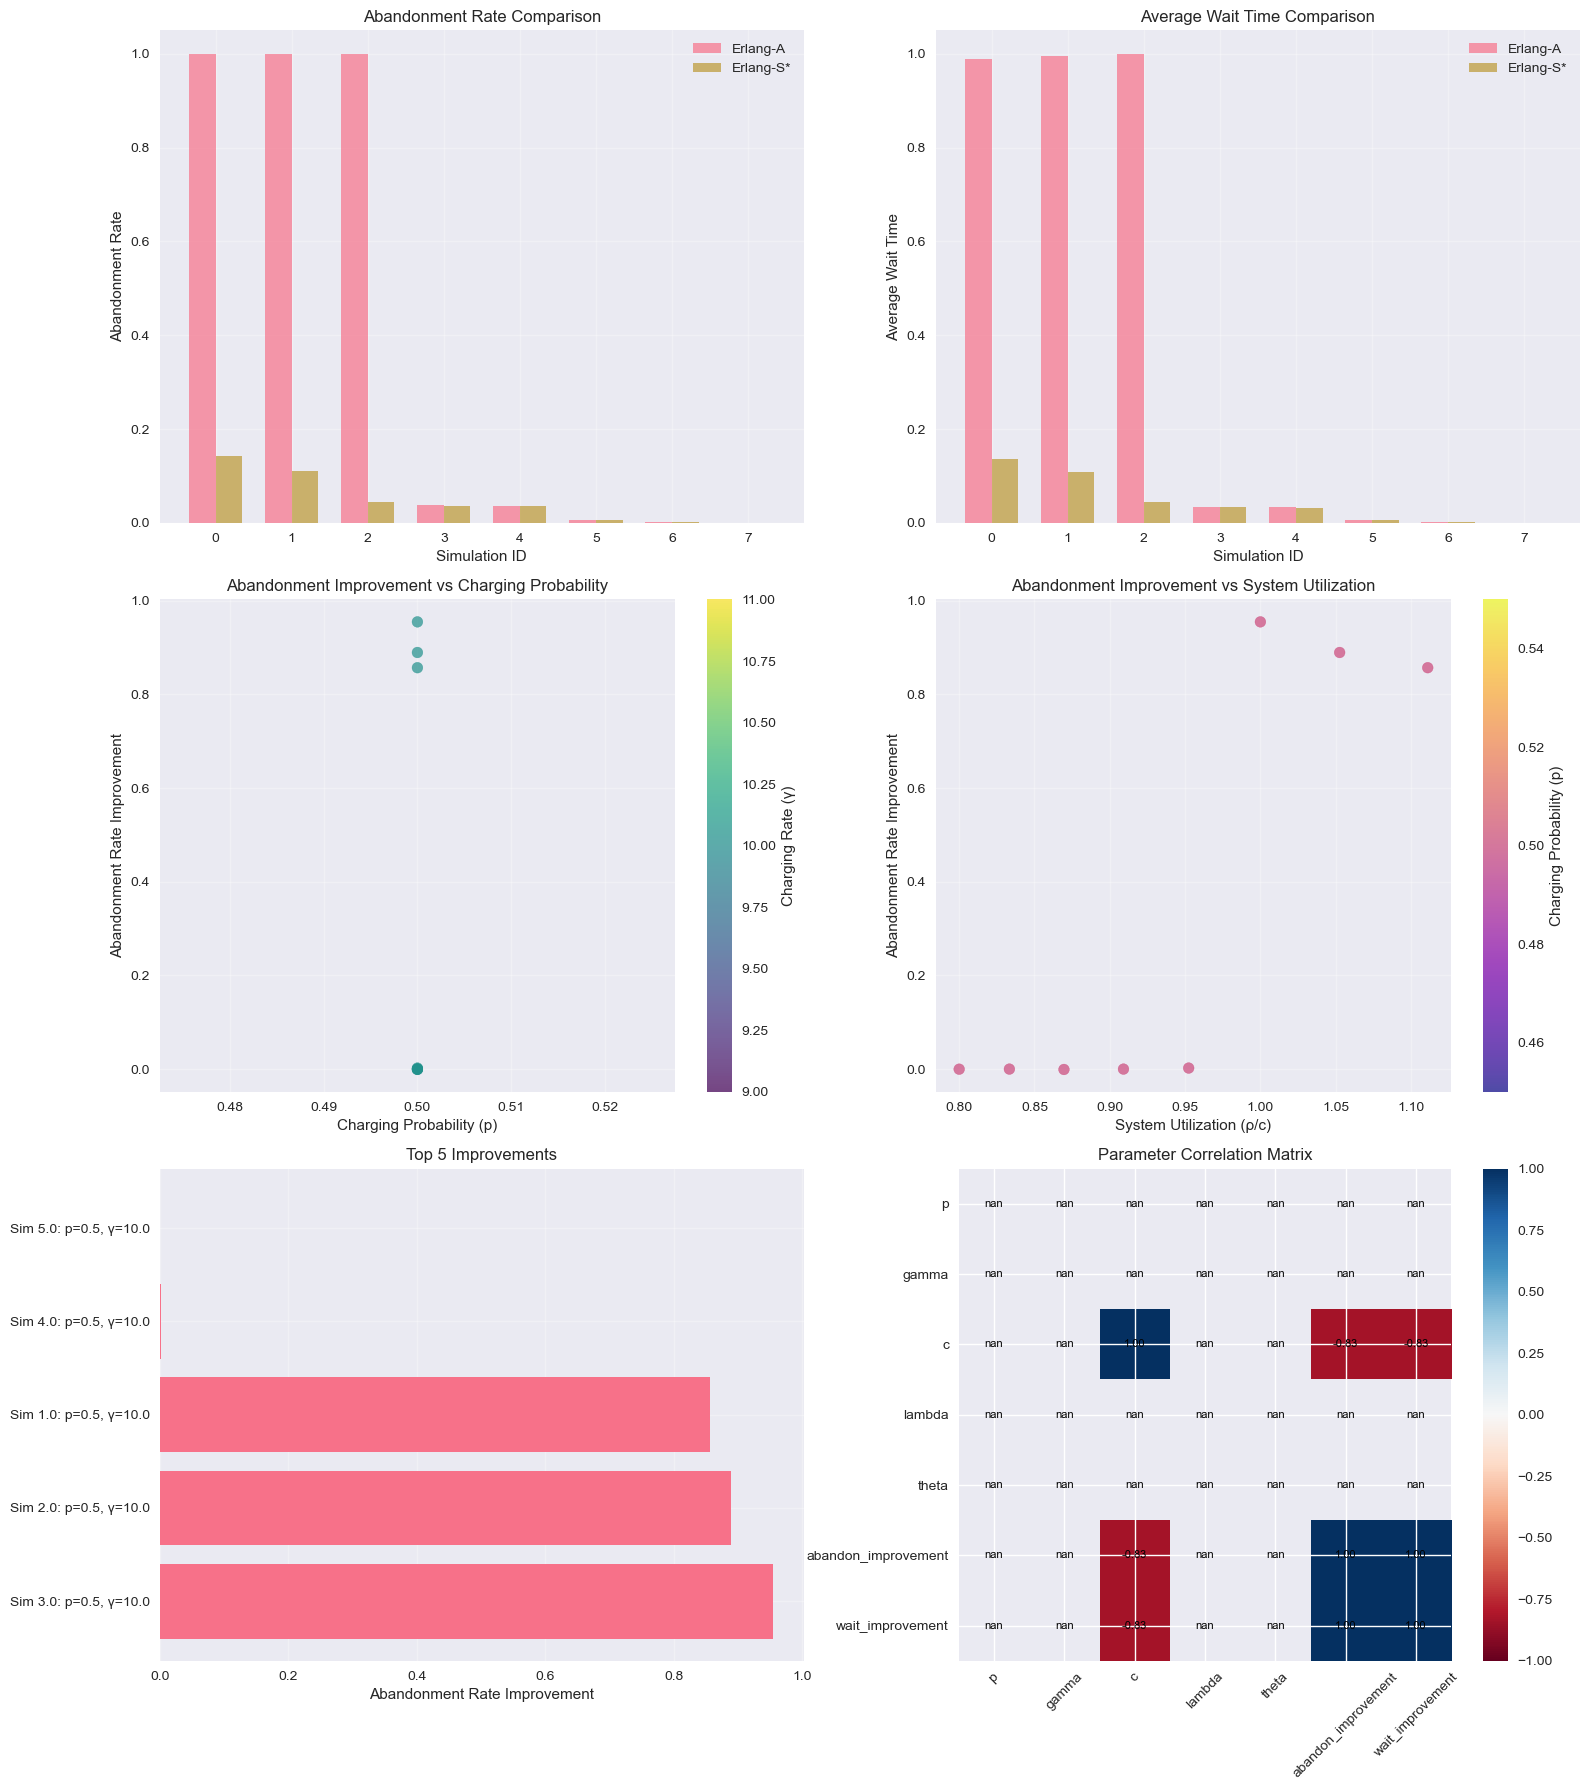

Summary saved to: simulation_results/parameter_sweep_20251106_015836/summary/parameter_sweep_summary.csv


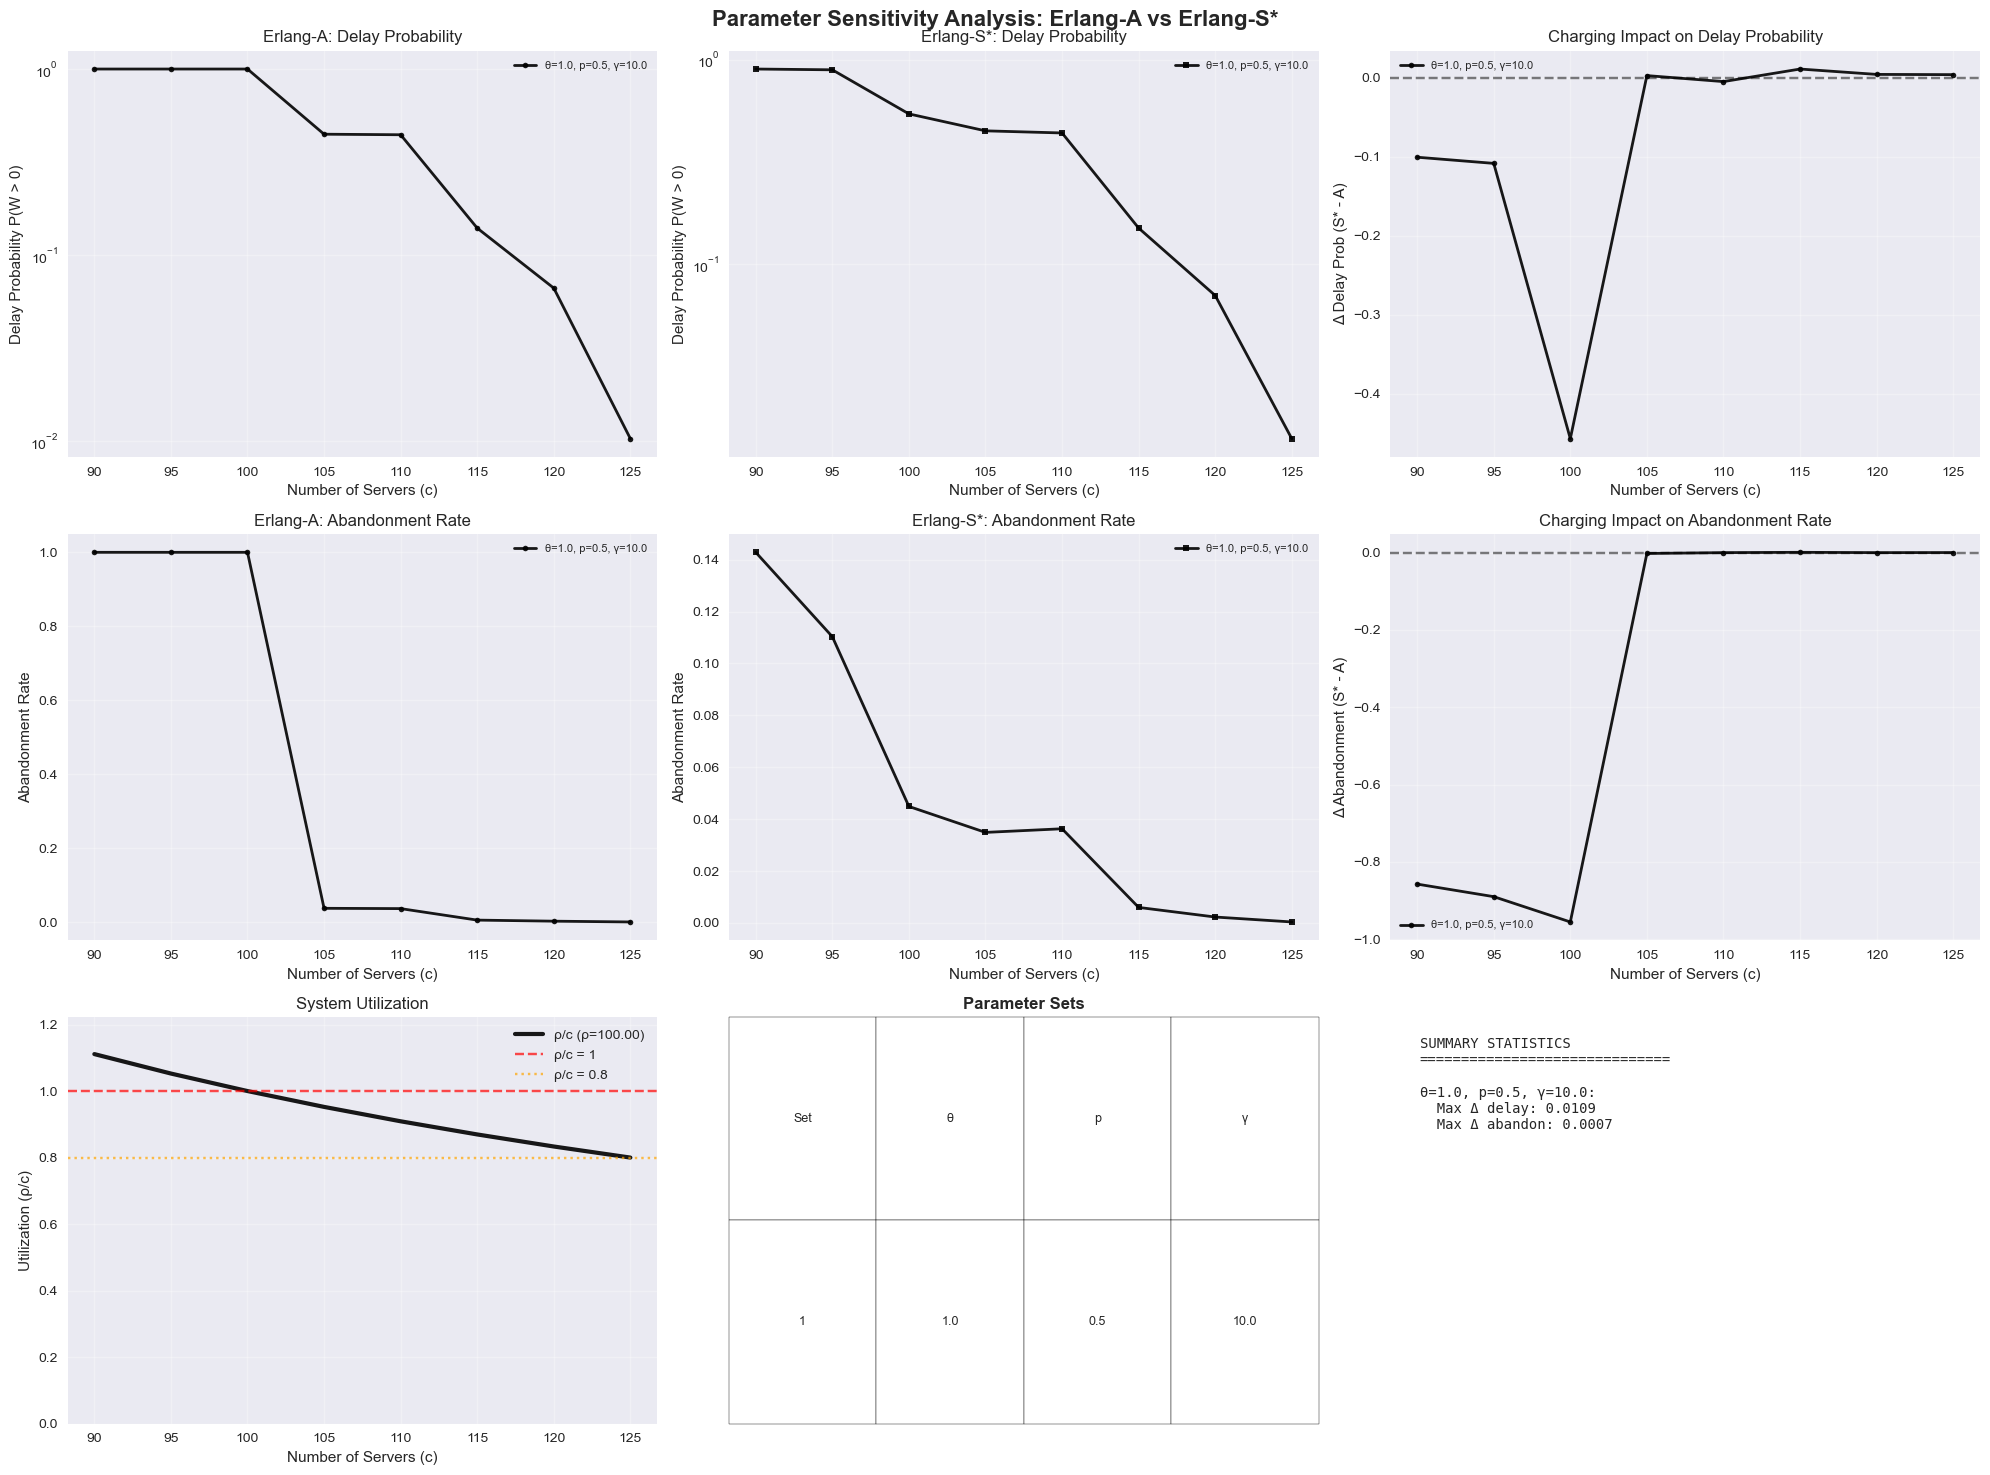

In [45]:
results_quick, sweep_dir_quick = run_parameter_sweep(expanded_parameter_sets[8:16], num_customers=10_000)
summary_quick = analyze_parameter_sweep_results(results_quick, sweep_dir_quick)

plot_parameter_comparison(summary_df_=summary_quick, results_=results_quick, max_groups=1)

In [13]:
# Example: save 3–5 sampled individual runs (FAST TEST)
# Note: adjust num_customers up for higher-fidelity snapshots.
try:
    
    small_params = [
        {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 1.0}, # OL
        {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 150, 'p': 0.5, 'gamma': 1.0}, # UL (in the boundary)
        {'lambda': 100.0,  'mu': 5.0, 'theta': 1.0, 'c': 100, 'p': 0.1, 'gamma': 0.5}, # UL
        {'lambda': 200.0,  'mu': 2.0, 'theta': 0.5, 'c': 125, 'p': 0.2, 'gamma': 2.0}, # UL
        {'lambda': 150.0,  'mu': 3.0, 'theta': 2.0, 'c': 130, 'p': 0.3, 'gamma': 0.5}, # OL
    ]
    _, sweep_directory = run_parameter_sweep(small_params, num_customers=1000000, charging_distr='lognormal')
    print(f'Using sweep directory: {sweep_directory}')
    sampled_index = save_sampled_individual_runs(
        parameter_sets=small_params,
        num_customers=1000000,  # keep modest to avoid large files
        sweep_dir=sweep_directory,
    )
    print(sampled_index)
except Exception as e:
    print('Sampled individual runs test skipped/error:', e)


Starting summary-only parameter sweep with 5 parameter sets
Each simulation uses 1,000,000 customers
Sweep directory: simulation_results/parameter_sweep_20251210_233538

RUN 1/5: λ=100.0, μ=1.0, θ=1.0, c=100, p=0.5, γ=1.0
  ✓ Completed sim 1: delay_a=1.0000, delay_s=0.9998, abandon_a=1.0000, abandon_s=0.3609

RUN 2/5: λ=100.0, μ=1.0, θ=1.0, c=150, p=0.5, γ=1.0
  ✓ Completed sim 1: delay_a=1.0000, delay_s=0.9998, abandon_a=1.0000, abandon_s=0.3609

RUN 2/5: λ=100.0, μ=1.0, θ=1.0, c=150, p=0.5, γ=1.0
  ✓ Completed sim 2: delay_a=0.5253, delay_s=0.6622, abandon_a=0.0412, abandon_s=0.0613

RUN 3/5: λ=100.0, μ=5.0, θ=1.0, c=100, p=0.1, γ=0.5
  ✓ Completed sim 2: delay_a=0.5253, delay_s=0.6622, abandon_a=0.0412, abandon_s=0.0613

RUN 3/5: λ=100.0, μ=5.0, θ=1.0, c=100, p=0.1, γ=0.5
  ✓ Completed sim 3: delay_a=0.0000, delay_s=0.0000, abandon_a=0.0000, abandon_s=0.0000

RUN 4/5: λ=200.0, μ=2.0, θ=0.5, c=125, p=0.2, γ=2.0
  ✓ Completed sim 3: delay_a=0.0000, delay_s=0.0000, abandon_a=0.0000, ab

In [39]:
# Helper: tolerance-based near-critical selection fix

def pick_representative_param_sets_with_tolerance(df_summary: pd.DataFrame,
                                                  ul_target: int = 2,
                                                  ol_target: int = 2,
                                                  nc_target: int = 1,
                                                  tol: float = 0.01) -> Dict[str, pd.DataFrame]:
    """
    Select UL/OL/NC representative parameter sets using a tolerance for near-critical.
    Assumes df_summary has columns 'regime' in {UL, OL, NC} or equivalently a scalar 'delta'
    where NC is defined by |delta| <= tol.
    Returns dict with keys 'UL', 'OL', 'NC'.
    """
    df = df_summary.copy()
    if 'regime' not in df.columns and 'delta' in df.columns:
        df['regime'] = df['delta'].apply(lambda d: 'NC' if abs(d) <= tol else ('UL' if d < -tol else 'OL'))

    out = {
        'UL': df[df['regime'] == 'UL'].head(ul_target),
        'OL': df[df['regime'] == 'OL'].head(ol_target),
        'NC': df[df['regime'] == 'NC'].head(nc_target),
    }

    # If NC not found, fallback: pick closest to critical by minimal |delta|
    if len(out['NC']) < nc_target:
        if 'delta' in df.columns:
            df_sorted = df.copy()
            df_sorted['abs_delta'] = df_sorted['delta'].abs()
            fallback = df_sorted.sort_values('abs_delta', ascending=True).head(nc_target)
            out['NC'] = fallback
        else:
            # If no delta present, just sample one additional from middle rows
            mid_idx = len(df)//2
            out['NC'] = df.iloc[[mid_idx]]
    return out


### Multiple of same Simulation Runs 

In [26]:
def save_same_sim_runs(parameter_sets: list,
                                 num_customers: int,
                                 sweep_dir: str,
                                 prefix: str = "sim",
                                 charging_distr: str = 'exponential',
                                 number_of_runs: int = 100
                                 ) -> pd.DataFrame:
    """
    Run and save detailed individual runs in sweep_dir/individual_runs using the
    same rich format (pickle + CSVs) as before.

    Returns a small DataFrame index with filenames and tags.
    """
    individual_dir = os.path.join(sweep_dir, "individual_runs")
    os.makedirs(individual_dir, exist_ok=True)

    selected = []

    for param in parameter_sets:
        regime = classify_regime(param['lambda'], param['mu'], param['theta'], param['p'], param['gamma'], param['c'])
        selected.append((param, regime))

    index_rows = []
    for idx, (params, tag) in enumerate(selected, start=1):
        print(f"Saving sampled run {idx}/{len(selected)} [{tag}] with params: "
              f"λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}, p={params['p']}, γ={params['gamma']}")
        # Match Erlang-A server adjustment from sweep logic
        if params['lambda']/params['mu'] + params['lambda']*params['p']/params['gamma'] <= params['c']:
            num_servers_a = int(params['c'] - params['lambda']*params['p']//params['gamma'])
        else:
            num = int(params['c'] * (params['gamma']//(params['gamma'] + params['p']*params['mu'])))
            num_servers_a = max(1,num)
        for run_id in range(number_of_runs):

            # Run Erlang-A
            sim_a = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=num_servers_a,
                p_charge=0.0,
                gamma_rate=params['gamma'],
                charging_distribution=charging_distr,
                random_seed=4451 * run_id + idx
            )
            customers_a = sim_a.simulate_erlang_a()
            # Run Erlang-S*
            sim_s = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=params['c'],
                p_charge=params['p'],
                gamma_rate=params['gamma'],
                charging_distribution=charging_distr,
                random_seed=4451 * run_id + idx
            )
            customers_s = sim_s.simulate_erlang_s()

            # Metrics and save
            df_delay = delay_probability(customers_a, customers_s, params)
            fname_prefix = f"{prefix}_{idx:02d}_{tag}_{run_id}_drone_delivery"
            files_saved, _ = save_simulation_results(
                customers_a=customers_a,
                customers_s=customers_s,
                df_delay=df_delay,
                params=params,
                save_dir=individual_dir,
                filename_prefix=fname_prefix
            )

            index_rows.append({
                'idx': idx,
                'run_id': run_id,
                'tag': tag,
                'lambda': params['lambda'], 'mu': params['mu'], 'theta': params['theta'],
                'c': params['c'], 'p': params['p'], 'gamma': params['gamma'],
                'csv_combined': os.path.basename(files_saved.get('csv_combined', '')),
            })

    df_index = pd.DataFrame(index_rows)
    # Write a compact index file
    index_path = os.path.join(sweep_dir, "summary", "sampled_runs_index.csv")
    try:
        df_index.to_csv(index_path, index=False)
        print(f"Sampled runs index saved: {index_path}")
    except Exception as e:
        print(f"Warning: could not save sampled runs index ({e}).")

    print(f"Saved {len(df_index)} sampled individual runs under: {individual_dir}")
    return df_index



In [27]:
try:
    
    small_params = [
        {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 100, 'p': 0.5, 'gamma': 1.0}, # OL
        {'lambda': 100.0, 'mu': 1.0, 'theta': 1.0, 'c': 150, 'p': 0.5, 'gamma': 1.0}, # UL (in the boundary)
        {'lambda': 100.0,  'mu': 5.0, 'theta': 1.0, 'c': 100, 'p': 0.1, 'gamma': 0.5}, # UL
    ]
    _, sweep_directory = run_parameter_sweep(small_params, num_customers=10000, charging_distr='lognormal')
    print(f'Using sweep directory: {sweep_directory}')
    sampled_index = save_same_sim_runs(
        parameter_sets=small_params,
        num_customers=10000,  # keep modest to avoid large files
        sweep_dir=sweep_directory,
    )
    print(sampled_index)
except Exception as e:
    print('Sampled individual runs test skipped/error:', e)

Starting summary-only parameter sweep with 3 parameter sets
Each simulation uses 10,000 customers
Sweep directory: simulation_results/parameter_sweep_20251212_035925

RUN 1/3: λ=100.0, μ=1.0, θ=1.0, c=100, p=0.5, γ=1.0
  ✓ Completed sim 1: delay_a=1.0000, delay_s=0.9870, abandon_a=1.0000, abandon_s=0.3521

RUN 2/3: λ=100.0, μ=1.0, θ=1.0, c=150, p=0.5, γ=1.0
  ✓ Completed sim 2: delay_a=0.5644, delay_s=0.6595, abandon_a=0.0407, abandon_s=0.0536

RUN 3/3: λ=100.0, μ=5.0, θ=1.0, c=100, p=0.1, γ=0.5
  ✓ Completed sim 3: delay_a=0.0000, delay_s=0.0000, abandon_a=0.0000, abandon_s=0.0000

PARAMETER SWEEP COMPLETED (summary-only mode)
Summary CSV: simulation_results/parameter_sweep_20251212_035925/summary/parameter_sweep_summary.csv
Metadata JSON: simulation_results/parameter_sweep_20251212_035925/summary/parameter_sets_20251212_035925.json
README: simulation_results/parameter_sweep_20251212_035925/README.md
Using sweep directory: simulation_results/parameter_sweep_20251212_035925
Saving samp